# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [423]:
import h2o
import os
import numpy as np
import math
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(max_mem_size='12G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,10 days 22 hours 8 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 3 days
H2O cluster name:,H2O_from_python_ngill_vo2rw9
H2O cluster total nodes:,1
H2O cluster free memory:,10.02 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [424]:
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [425]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (160338, 23)
Test shape: (39662, 22)


In [426]:
train.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
2.5493e+06,175000,97,1,0,185000,36,0,47,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1
4.00076e+06,265000,95,1,0,285000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5
1.54693e+06,115000,97,0,120,125000,59,0,39,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5
5.45314e+06,275000,57.9,1,0,475000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
4.94313e+06,155000,99,1,0,155000,42,0,46,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4
1.23729e+06,215000,95,1,0,225000,81,0,42,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
682016,195000,95,1,0,205000,92,0,49,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1
19740,125000,100,1,0,125000,38,0,43,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2
5.36388e+06,355000,90,1,0,395000,95,0,38,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5
1.94229e+06,595000,80,1,0,745000,371,0,nan,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4


In [427]:
train.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
type,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,49.0,5000.0,1.0,0.0,0.0,5000.0,-130.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
mean,3319386.4112125635,291981.00263194024,86.64662923818423,0.9436378151155683,5.35342838254188,358807.76858885604,152.333788621537,0.09670196709451284,42.51917601153023,0.9603275580336539,0.928027042871933,0.0787575295739894,0.07867769794614994,0.8355541040714131,0.004434284055446694,0.0025763843530009433,0.12107167983057363,0.8789283201694263,0.6126165686353814,0.3873834313646186,0.21633871324342252,0.7836612867565775,3.0030373336327
maxs,6504996.0,12005000.0,900.0,1.0,425.0,13605000.0,882000.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
sigma,1952820.8522752034,227416.2209992358,15.01109708563018,0.2306205123360138,24.864561487883368,324310.1569850146,2886.174831533794,0.295552434347859,3.973609138536163,0.1951890799460008,0.25844393424533546,0.26936092454879995,0.2692360374620666,0.3706810494787445,0.06644285679708556,0.05069285202604093,0.3262117410182472,0.3262117410182472,0.48715526363003847,0.48715526363003847,0.41175035739904686,0.41175035739904686,1.4115197617501203
zeros,0,0,0,9037,151301,0,982,144833,0,6361,11540,126938,126949,22659,137179,137435,121184,16693,33523,53014,63801,17613,0
missing,0,0,0,0,0,0,0,0,74997,0,0,22548,22548,22548,22548,22548,22461,22461,73801,73801,78924,78924,0
0,2549300.0,175000.0,97.0,1.0,0.0,185000.0,36.0,0.0,47.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,1.0,0.0,1.0
1,4000757.0,265000.0,95.0,1.0,0.0,285000.0,100.0,0.0,nan,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,1.0,0.0,5.0
2,1546928.0,115000.0,97.0,0.0,120.0,125000.0,59.0,0.0,39.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,5.0


In [428]:
print(f"Min for train loan_to_value_ratio: {train['loan_to_value_ratio'].min()}")
print(f"Max for train loan_to_value_ratio: {train['loan_to_value_ratio'].max()}")

Min for train loan_to_value_ratio: 1.0
Max for train loan_to_value_ratio: 900.0


In [436]:
ltv_train = train['loan_to_value_ratio'].as_data_frame().values

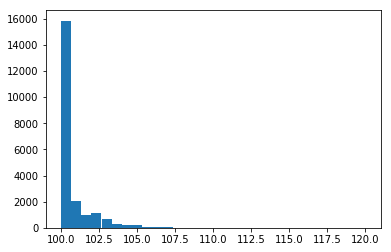

In [437]:
plt.hist(ltv_train, bins=30, range=(100,120))
plt.show()

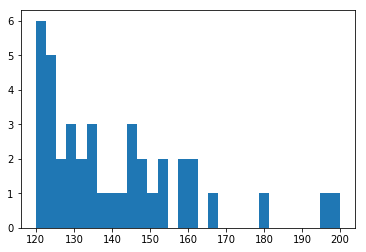

In [438]:
plt.hist(ltv_train, bins=30, range=(120,200))
plt.show()

In [439]:
test.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
131497,185000,96.5,1,0,195000,129,0,nan,1,1,0,1,0,0,0,1,0,1,0,nan,nan
851117,365000,95,0,85,385000,121,0,nan,1,1,0,1,0,0,0,0,1,1,0,nan,nan
835616,265000,96.28,1,0,265000,106,0,49,1,1,0,0,1,0,0,0,1,nan,nan,0,1
121491,145000,56.91,1,0,255000,68,0,38,0,1,0,0,1,0,0,0,1,1,0,1,0
4.47964e+06,355000,95,1,0,375000,154,0,46,1,1,0,0,1,0,0,0,1,nan,nan,0,1
843194,365000,96.5,1,0,375000,51,1,nan,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1
6.37726e+06,195000,96.5,1,0,205000,54,0,nan,1,1,0,0,1,0,0,0,1,0,1,nan,nan
5.25537e+06,135000,80,1,0,165000,81,0,48,1,1,0,0,1,0,0,1,0,0,1,nan,nan
4.59782e+06,455000,68.76,0,120,655000,82,0,41,1,1,0,1,0,0,0,0,1,1,0,nan,nan
6.13819e+06,325000,80,1,0,405000,65,0,49,1,1,0,0,1,0,0,0,1,nan,nan,1,0


In [440]:
test.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
type,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,4056.0,5000.0,1.0,0.0,0.0,25000.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3323235.64242852,292912.61156774743,88.56029290647881,0.9412283798093893,5.4916040542584845,360743.028591599,182.90381221320155,0.09752407846301246,42.49417061611374,0.9601885936160557,0.9262014018455953,0.07671265111627497,0.08197782157249169,0.8342206665293996,0.004294496573227049,0.0027943642086066416,0.12101442886949366,0.8789855711305063,0.6133134578655611,0.3866865421344389,0.22066733067729083,0.7793326693227092
maxs,6504997.0,4625000.0,79474.0,1.0,360.0,9245000.0,396000.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,1954622.3871122967,224087.83385259155,398.9005406950038,0.23519972706038758,24.4766458606141,321800.26166856906,3600.669509692802,0.29667381367158185,3.9708418924862814,0.19551834219733183,0.2614461483363615,0.2661388804577039,0.27433496324350387,0.3718879052734942,0.06539250456663769,0.05278861339759911,0.3261488353928688,0.3261488353928688,0.487002164716498,0.487002164716498,0.4147069141947798,0.4147069141947798
zeros,0,0,0,2331,37331,0,231,35794,0,1579,2927,31389,31210,5636,33851,33902,29911,4118,8301,13166,15649,4431
missing,0,0,0,0,0,0,0,0,18562,0,0,5665,5665,5665,5665,5665,5633,5633,18195,18195,19582,19582
0,131497.0,185000.0,96.5,1.0,0.0,195000.0,129.0,0.0,nan,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,nan,nan
1,851117.0,365000.0,95.0,0.0,85.0,385000.0,121.0,0.0,nan,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,nan,nan
2,835616.0,265000.0,96.28,1.0,0.0,265000.0,106.0,0.0,49.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,0.0,1.0


In [433]:
print(f"Min for test loan_to_value_ratio: {test['loan_to_value_ratio'].min()}")
print(f"Max for test loan_to_value_ratio: {test['loan_to_value_ratio'].max()}")

Min for test loan_to_value_ratio: 1.0
Max for test loan_to_value_ratio: 79474.0


In [441]:
ltv_test = test['loan_to_value_ratio'].as_data_frame().values

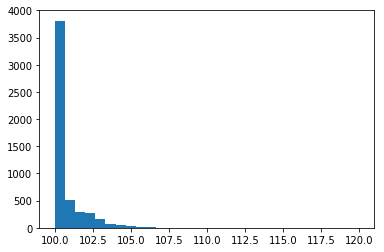

In [442]:
plt.hist(ltv_test, bins=30, range=(100,120))
plt.show()

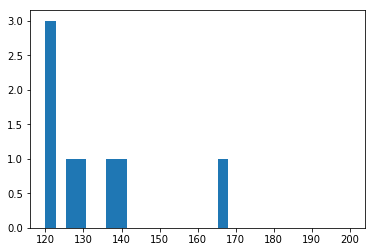

In [443]:
plt.hist(ltv_test, bins=30, range=(120,200))
plt.show()

In [444]:
# Feature Engineering

# Train
train['loan_amount_conforming'] = (train["conforming"] == 1).ifelse(train['loan_amount'], np.nan)
train['loan_amount_non_conforming'] = (train["conforming"] == 0).ifelse(train['loan_amount'], np.nan)
train['loan_to_value_ratio_manual'] = train['loan_amount'] / train['property_value'] * 100
train['loan_to_value_ratio_manual'] = train['loan_to_value_ratio_manual'].round()

#Test
test['loan_amount_conforming'] = (test["conforming"] == 1).ifelse(test['loan_amount'], np.nan)
test['loan_amount_non_conforming'] = (test["conforming"] == 0).ifelse(test['loan_amount'], np.nan)
test['loan_to_value_ratio_manual'] = (test['loan_amount'] / test['property_value'] * 100)
test['loan_to_value_ratio_manual'] = test['loan_to_value_ratio_manual'].round()

In [445]:
train.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual
2.5493e+06,175000,97,1,0,185000,36,0,47,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1,175000,nan,95
4.00076e+06,265000,95,1,0,285000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5,265000,nan,93
1.54693e+06,115000,97,0,120,125000,59,0,39,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5,115000,nan,92
5.45314e+06,275000,57.9,1,0,475000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,275000,nan,58
4.94313e+06,155000,99,1,0,155000,42,0,46,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4,155000,nan,100
1.23729e+06,215000,95,1,0,225000,81,0,42,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,215000,nan,96
682016,195000,95,1,0,205000,92,0,49,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1,195000,nan,95
19740,125000,100,1,0,125000,38,0,43,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2,125000,nan,100
5.36388e+06,355000,90,1,0,395000,95,0,38,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5,355000,nan,90
1.94229e+06,595000,80,1,0,745000,371,0,nan,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4,nan,595000,80


In [446]:
test.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual
131497,185000,96.5,1,0,195000,129,0,nan,1,1,0,1,0,0,0,1,0,1,0,nan,nan,185000,nan,95
851117,365000,95,0,85,385000,121,0,nan,1,1,0,1,0,0,0,0,1,1,0,nan,nan,365000,nan,95
835616,265000,96.28,1,0,265000,106,0,49,1,1,0,0,1,0,0,0,1,nan,nan,0,1,265000,nan,100
121491,145000,56.91,1,0,255000,68,0,38,0,1,0,0,1,0,0,0,1,1,0,1,0,145000,nan,57
4.47964e+06,355000,95,1,0,375000,154,0,46,1,1,0,0,1,0,0,0,1,nan,nan,0,1,355000,nan,95
843194,365000,96.5,1,0,375000,51,1,nan,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1,365000,nan,97
6.37726e+06,195000,96.5,1,0,205000,54,0,nan,1,1,0,0,1,0,0,0,1,0,1,nan,nan,195000,nan,95
5.25537e+06,135000,80,1,0,165000,81,0,48,1,1,0,0,1,0,0,1,0,0,1,nan,nan,135000,nan,82
4.59782e+06,455000,68.76,0,120,655000,82,0,41,1,1,0,1,0,0,0,0,1,1,0,nan,nan,455000,nan,69
6.13819e+06,325000,80,1,0,405000,65,0,49,1,1,0,0,1,0,0,0,1,nan,nan,1,0,325000,nan,80


In [447]:
# Inputs and output
X = ['loan_amount_conforming', 'loan_amount_non_conforming', 'loan_to_value_ratio_manual', 'no_intro_rate_period', 'intro_rate_period',
    'property_value', 'income', "debt_to_income_ratio", "term_360", "conforming"]
fold_column = 'cv_fold'
Y = "high_priced"

In [448]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [449]:
# Distribution of outcome in train
train[Y].table()

high_priced,Count
0,144833
1,15505


In [450]:
# Distribution of outcome in test
test[Y].table()

high_priced,Count
0,35794
1,3868


In [451]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [452]:
# Create Pandas frame for correlation purposes
train_pd_for_corr = train.as_data_frame()

In [453]:
# Get correlation
numeric_corr = pd.DataFrame(train_pd_for_corr[X + [Y]].corr()[Y]).iloc[:-1]
numeric_corr

,high_priced
loan_amount_conforming,-0.139775
loan_amount_non_conforming,-0.005549
loan_to_value_ratio_manual,0.111645
no_intro_rate_period,0.018108
intro_rate_period,-0.031716
property_value,-0.137319
income,-0.007911
debt_to_income_ratio,0.031007
term_360,0.052448
conforming,0.074543


In [454]:
# Filter to correlations > 0.1
numeric_corr = numeric_corr[numeric_corr['high_priced'].abs() > 0.1]
numeric_corr

,high_priced
loan_amount_conforming,-0.139775
loan_to_value_ratio_manual,0.111645
property_value,-0.137319


In [455]:
# Apply monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train_pd_for_corr[list(numeric_corr.index) + [Y]].corr()[Y].values[:-1])])
mono_constraints = dict(zip(list(numeric_corr.index.tolist()), mono_constraints))
#del mono_constraints['loan_amount_conforming']
#del mono_constraints['property_value']
mono_constraints

{'loan_amount_conforming': -1,
 'loan_to_value_ratio_manual': 1,
 'property_value': -1}

In [456]:
# Default GBM with monotonic constraints
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED,
               categorical_encoding="one_hot_explicit")
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [457]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_42305


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,16073.0,5.0,5.0,5.0,14.0,29.0,20.98




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07933489572265526
RMSE: 0.28166450916410335
LogLoss: 0.2675153535439777
Mean Per-Class Error: 0.2646148704179936
AUC: 0.7886934869285664
pr_auc: 0.23662763841349788
Gini: 0.5773869738571329

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1317844861338725: 


,,0,1,Error,Rate
0,0,102068.0,42765.0,0.2953,(42765.0/144833.0)
1,1,4120.0,11385.0,0.2657,(4120.0/15505.0)
2,Total,106188.0,54150.0,0.2924,(46885.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.131784,0.326897,233.0
1,max f2,0.103632,0.507135,260.0
2,max f0point5,0.203468,0.264825,163.0
3,max accuracy,0.912300,0.903304,0.0
4,max precision,0.912300,1.000000,0.0
5,max recall,0.005145,1.000000,398.0
6,max specificity,0.912300,1.000000,0.0
7,max absolute_mcc,0.114555,0.284757,250.0
8,max min_per_class_accuracy,0.135207,0.712480,230.0
9,max mean_per_class_accuracy,0.103632,0.735385,260.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.64 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010079,0.381414,3.762709,3.762709,0.363861,0.447555,0.363861,0.447555,0.037923,0.037923,276.270925,276.270925
1,,2,0.020270,0.331774,2.847903,3.302773,0.275398,0.357397,0.319385,0.402226,0.029023,0.066946,184.790274,230.277268
2,,3,0.030405,0.280762,2.870039,3.158528,0.277538,0.301821,0.305436,0.368758,0.029087,0.096034,187.003946,215.852828
3,,4,0.040134,0.271630,2.870305,3.088656,0.277564,0.274239,0.298679,0.345844,0.027926,0.123960,187.030462,208.865587
4,,5,0.050506,0.264451,2.344303,2.935796,0.226699,0.268299,0.283897,0.329920,0.024315,0.148275,134.430327,193.579611
5,,6,0.100064,0.216721,2.454471,2.697413,0.237352,0.233038,0.260845,0.281938,0.121638,0.269913,145.447051,169.741334
6,,7,0.150008,0.195813,2.151373,2.515612,0.208042,0.206217,0.243265,0.256727,0.107449,0.377362,115.137256,151.561163
7,,8,0.200950,0.180274,2.094038,2.408740,0.202498,0.189086,0.232930,0.239579,0.106675,0.484037,109.403756,140.873960
8,,9,0.300228,0.151061,1.865781,2.229197,0.180425,0.165497,0.215568,0.215082,0.185231,0.669268,86.578083,122.919708
9,,10,0.400878,0.102702,1.553272,2.059490,0.150204,0.126312,0.199157,0.192794,0.156337,0.825605,55.327229,105.949028




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.0795677513855506
RMSE: 0.28207756271201473
LogLoss: 0.26847880968274995
Mean Per-Class Error: 0.2659071900249679
AUC: 0.7861508144510164
pr_auc: 0.23215880637748854
Gini: 0.5723016289020328

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15663984519407817: 


,,0,1,Error,Rate
0,0,109158.0,35675.0,0.2463,(35675.0/144833.0)
1,1,5580.0,9925.0,0.3599,(5580.0/15505.0)
2,Total,114738.0,45600.0,0.2573,(41255.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.156640,0.324851,214.0
1,max f2,0.102584,0.505637,267.0
2,max f0point5,0.206573,0.262854,158.0
3,max accuracy,0.908485,0.903292,0.0
4,max precision,0.423223,0.347032,52.0
5,max recall,0.004181,1.000000,399.0
6,max specificity,0.908485,0.999993,0.0
7,max absolute_mcc,0.106413,0.282314,263.0
8,max min_per_class_accuracy,0.135434,0.711454,235.0
9,max mean_per_class_accuracy,0.102584,0.734093,267.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.65 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010041,0.382304,3.506965,3.506965,0.339130,0.447702,0.339130,0.447702,0.035214,0.035214,250.696521,250.696521
1,,2,0.020058,0.334571,3.032774,3.270165,0.293275,0.355566,0.316231,0.401692,0.030377,0.065592,203.277407,227.016454
2,,3,0.030086,0.282852,2.707452,3.082594,0.261816,0.302506,0.298093,0.368630,0.027153,0.092744,170.745186,208.259364
3,,4,0.040015,0.270867,2.708680,2.989815,0.261935,0.276171,0.289121,0.345688,0.026895,0.119639,170.867989,198.981454
4,,5,0.050063,0.261266,2.497001,2.890908,0.241465,0.266275,0.279556,0.329750,0.025089,0.144728,149.700121,189.090807
5,,6,0.100026,0.216293,2.411320,2.651353,0.233179,0.233364,0.256391,0.281605,0.120477,0.265205,141.131991,165.135321
6,,7,0.150039,0.197029,2.176792,2.493166,0.210500,0.206020,0.241094,0.256410,0.108868,0.374073,117.679194,149.316612
7,,8,0.200015,0.178566,2.089375,2.392275,0.202047,0.189518,0.231338,0.239696,0.104418,0.478491,108.937502,139.227500
8,,9,0.300022,0.148873,1.872804,2.219118,0.181104,0.164618,0.214593,0.214670,0.187294,0.665785,87.280405,121.911802
9,,10,0.400099,0.103608,1.563467,2.055121,0.151190,0.126916,0.198734,0.192720,0.156466,0.822251,56.346693,105.512093




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7078861,0.026257029,0.7226218,0.72432435,0.7334769,0.68098027,0.67802715
1,auc,0.7863428,0.0041379947,0.782654,0.79284585,0.7845992,0.7879266,0.78368837
2,err,0.29211393,0.026257029,0.2773782,0.27567568,0.26652312,0.31901973,0.32197288
3,err_count,9370.6,888.8449,8870.0,8772.0,8541.0,10297.0,10373.0
4,f0point5,0.24527399,0.007870752,0.24452995,0.25765008,0.24598697,0.23615476,0.24204822
5,f1,0.3262709,0.0069669033,0.3223835,0.3378623,0.32241175,0.3210023,0.3276946
6,f2,0.48788834,0.017169954,0.4729669,0.49059582,0.46772859,0.5010086,0.5071417
7,lift_top_group,3.5365438,0.18067847,3.7537308,3.5054636,3.687486,3.4058247,3.3302147
8,logloss,0.26848793,0.0038931724,0.26892483,0.2723038,0.26577774,0.26339573,0.27203754
9,max_per_class_error,0.32176465,0.015917905,0.31315103,0.2977722,0.331359,0.33141783,0.33512324



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-03 10:25:36,19.616 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-12-03 10:25:36,19.680 sec,1.0,0.293249,0.310209,0.765908,0.220467,3.471004,0.267591
2,,2019-12-03 10:25:36,19.737 sec,2.0,0.291473,0.304621,0.768227,0.222191,3.471004,0.287331
3,,2019-12-03 10:25:36,19.795 sec,3.0,0.290073,0.300285,0.767200,0.221973,3.471004,0.296792
4,,2019-12-03 10:25:36,19.853 sec,4.0,0.288933,0.296752,0.766562,0.227454,3.471004,0.299012
5,,2019-12-03 10:25:36,19.910 sec,5.0,0.287907,0.293476,0.769959,0.228477,3.853808,0.261678
6,,2019-12-03 10:25:36,19.971 sec,6.0,0.287130,0.291014,0.769236,0.229251,3.835176,0.260387
7,,2019-12-03 10:25:36,20.037 sec,7.0,0.286471,0.288884,0.769056,0.229663,3.851547,0.259945
8,,2019-12-03 10:25:36,20.103 sec,8.0,0.285881,0.286868,0.770439,0.229818,3.858032,0.278399
9,,2019-12-03 10:25:37,20.176 sec,9.0,0.285445,0.285434,0.770102,0.230390,3.858032,0.278424



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,3846.603760,1.000000,0.534172
1,property_value,1599.517212,0.415826,0.222122
2,loan_amount_conforming,625.621033,0.162642,0.086879
3,intro_rate_period,564.312805,0.146704,0.078365
4,debt_to_income_ratio,271.226440,0.070511,0.037665
5,no_intro_rate_period,128.446671,0.033392,0.017837
6,term_360,79.788864,0.020743,0.011080
7,income,45.824688,0.011913,0.006364
8,loan_amount_non_conforming,39.456882,0.010258,0.005479
9,conforming,0.266125,0.000069,0.000037


In [458]:
# Get the AUC on the test set for MGBM
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.7891909843578667


In [459]:
# Get the AUC on 5 fold CV for MGBM
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.7861508144510164


In [460]:
# Default GBM
gbm_default = H2OGradientBoostingEstimator(
               seed=SEED,
               categorical_encoding="one_hot_explicit")
gbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [461]:
gbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_42601


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,21797.0,5.0,5.0,5.0,20.0,32.0,30.1




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07689638117853816
RMSE: 0.2773019674984982
LogLoss: 0.25699573878765214
Mean Per-Class Error: 0.2414819440445608
AUC: 0.8110950613620576
pr_auc: 0.2796347277833918
Gini: 0.6221901227241151

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1630041660890534: 


,,0,1,Error,Rate
0,0,103147.0,41686.0,0.2878,(41686.0/144833.0)
1,1,3360.0,12145.0,0.2167,(3360.0/15505.0)
2,Total,106507.0,53831.0,0.2809,(45046.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.163004,0.350323,212.0
1,max f2,0.114953,0.533561,249.0
2,max f0point5,0.217992,0.286977,148.0
3,max accuracy,0.403734,0.904221,46.0
4,max precision,0.745048,1.000000,0.0
5,max recall,0.005002,1.000000,399.0
6,max specificity,0.745048,1.000000,0.0
7,max absolute_mcc,0.151297,0.314563,226.0
8,max min_per_class_accuracy,0.171104,0.733300,203.0
9,max mean_per_class_accuracy,0.085488,0.758518,268.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010160,0.322036,5.059434,5.059434,0.489257,0.399057,0.489257,0.399057,0.051403,0.051403,405.943393,405.943393
1,,2,0.020001,0.288919,2.994842,4.043554,0.289607,0.305252,0.391020,0.352900,0.029474,0.080877,199.484185,304.355419
2,,3,0.030698,0.269146,3.105330,3.716644,0.300292,0.274683,0.359407,0.325647,0.033215,0.114092,210.533027,271.664358
3,,4,0.043034,0.263670,2.959067,3.499472,0.286148,0.265437,0.338406,0.308387,0.036504,0.150597,195.906725,249.947170
4,,5,0.050238,0.259898,2.882960,3.411071,0.278788,0.262171,0.329857,0.301760,0.020767,0.171364,188.295975,241.107054
5,,6,0.100326,0.230136,2.446519,2.929515,0.236583,0.247221,0.283290,0.274531,0.122541,0.293905,144.651941,192.951453
6,,7,0.150201,0.211659,2.406489,2.755839,0.232712,0.218353,0.266495,0.255876,0.120026,0.413931,140.648949,175.583885
7,,8,0.200015,0.199215,2.149261,2.604771,0.207838,0.205128,0.251886,0.243238,0.107062,0.520993,114.926069,160.477119
8,,9,0.301931,0.175268,1.954807,2.385378,0.189034,0.187505,0.230671,0.224425,0.199226,0.720219,95.480738,138.537769
9,,10,0.400173,0.086282,1.494831,2.166749,0.144553,0.148158,0.209529,0.205702,0.146856,0.867075,49.483074,116.674865




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07745978526982422
RMSE: 0.27831598098173277
LogLoss: 0.25934018840422635
Mean Per-Class Error: 0.24426963311521865
AUC: 0.8055607252746407
pr_auc: 0.263521427249809
Gini: 0.6111214505492815

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16363699661348421: 


,,0,1,Error,Rate
0,0,103524.0,41309.0,0.2852,(41309.0/144833.0)
1,1,3583.0,11922.0,0.2311,(3583.0/15505.0)
2,Total,107107.0,53231.0,0.28,(44892.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.163637,0.346892,222.0
1,max f2,0.099415,0.530012,267.0
2,max f0point5,0.216742,0.282338,157.0
3,max accuracy,0.476683,0.903691,28.0
4,max precision,0.612326,0.775000,10.0
5,max recall,0.005070,1.000000,399.0
6,max specificity,0.821368,0.999993,0.0
7,max absolute_mcc,0.137712,0.310398,245.0
8,max min_per_class_accuracy,0.169763,0.731429,215.0
9,max mean_per_class_accuracy,0.093256,0.755730,271.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010023,0.327798,4.453023,4.453023,0.430616,0.395963,0.430616,0.395963,0.044631,0.044631,345.302270,345.302270
1,,2,0.020001,0.291474,3.037684,3.746898,0.293750,0.307724,0.362332,0.351940,0.030313,0.074944,203.768381,274.689790
2,,3,0.030005,0.274175,2.984979,3.492872,0.288653,0.281360,0.337768,0.328408,0.029861,0.104805,198.497926,249.287223
3,,4,0.040028,0.265461,2.934362,3.353027,0.283759,0.269409,0.324244,0.313636,0.029410,0.134215,193.436178,235.302706
4,,5,0.050032,0.260039,2.798015,3.242052,0.270574,0.262458,0.313513,0.303403,0.027991,0.162206,179.801512,224.205235
5,,6,0.100001,0.228975,2.491042,2.866781,0.240889,0.245662,0.277223,0.274550,0.124476,0.286682,149.104206,186.678140
6,,7,0.150077,0.210306,2.293861,2.675618,0.221821,0.217472,0.258737,0.255505,0.114866,0.401548,129.386129,167.561756
7,,8,0.200052,0.199705,2.124219,2.537871,0.205416,0.205522,0.245417,0.243019,0.106159,0.507707,112.421944,153.787117
8,,9,0.300004,0.174194,2.005490,2.360499,0.193935,0.186636,0.228265,0.224234,0.200451,0.708159,100.549029,136.049942
9,,10,0.399999,0.089253,1.536355,2.154473,0.148569,0.147798,0.208342,0.205126,0.153628,0.861787,53.635528,115.447302




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.72492146,0.008039739,0.73366064,0.73350096,0.71693814,0.71945965,0.7210479
1,auc,0.8057819,0.0036937087,0.8056663,0.81034654,0.80145097,0.8084579,0.8029879
2,err,0.27507854,0.008039739,0.26633936,0.26649904,0.28306186,0.28054032,0.2789521
3,err_count,8822.0,297.281,8517.0,8480.0,9071.0,9055.0,8987.0
4,f0point5,0.26229447,0.008231489,0.26286954,0.2747809,0.25335434,0.2566027,0.26386493
5,f1,0.34734792,0.008489906,0.34620404,0.3603862,0.33793154,0.34255427,0.3496635
6,f2,0.514175,0.007131811,0.506901,0.5234673,0.507275,0.515088,0.5181436
7,lift_top_group,4.4534345,0.20348565,4.590527,4.3818293,4.1262717,4.598958,4.5695863
8,logloss,0.25935048,0.0042328034,0.25871447,0.2636432,0.2578245,0.2533741,0.26319608
9,max_per_class_error,0.27847204,0.010299573,0.26638067,0.26829183,0.28775814,0.2863691,0.2835605



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-03 10:26:17,17.897 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-12-03 10:26:17,17.952 sec,1.0,0.292622,0.308192,0.788840,0.237923,3.627060,0.340830
2,,2019-12-03 10:26:17,17.999 sec,2.0,0.290220,0.300664,0.792112,0.241397,3.704893,0.274059
3,,2019-12-03 10:26:17,18.044 sec,3.0,0.288302,0.294728,0.793310,0.242219,3.704893,0.279653
4,,2019-12-03 10:26:17,18.090 sec,4.0,0.286706,0.289799,0.795029,0.248804,4.316959,0.275300
5,,2019-12-03 10:26:17,18.142 sec,5.0,0.285328,0.285527,0.797335,0.250123,4.316959,0.321458
6,,2019-12-03 10:26:17,18.194 sec,6.0,0.284245,0.282066,0.797461,0.251245,4.301406,0.322151
7,,2019-12-03 10:26:17,18.245 sec,7.0,0.283308,0.279044,0.798258,0.252550,4.254375,0.320598
8,,2019-12-03 10:26:17,18.298 sec,8.0,0.282535,0.276485,0.798883,0.253567,4.290624,0.271470
9,,2019-12-03 10:26:17,18.351 sec,9.0,0.281925,0.274399,0.800154,0.254687,4.271304,0.279971



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,4902.114746,1.000000,0.576878
1,property_value,1852.255127,0.377848,0.217972
2,intro_rate_period,634.687378,0.129472,0.074690
3,loan_amount_conforming,415.683838,0.084797,0.048917
4,debt_to_income_ratio,295.166199,0.060212,0.034735
5,no_intro_rate_period,176.666489,0.036039,0.020790
6,income,140.363678,0.028633,0.016518
7,term_360,68.090675,0.013890,0.008013
8,loan_amount_non_conforming,12.627782,0.002576,0.001486
9,conforming,0.000000,0.000000,0.000000


In [462]:
# Get the AUC on the test set for the default GBM
perf_gbm_default = gbm_default.model_performance(test)
print(perf_gbm_default.auc())

0.8085086439703604


In [463]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_gbm_default = gbm_default.model_performance(xval=True)
print(perf_cv_gbm_default.auc())

0.8055607252746407


PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42305 on column 'property_value'


,property_value,mean_response,stddev_response,std_error_mean_response
0,2.500000e+04,0.165820,0.127621,0.000641
1,5.102632e+05,0.048245,0.040317,0.000202
2,9.955263e+05,0.045979,0.038963,0.000196
3,1.480789e+06,0.045978,0.038963,0.000196
4,1.966053e+06,0.045961,0.038968,0.000196
5,2.451316e+06,0.045961,0.038968,0.000196
6,2.936579e+06,0.045958,0.038970,0.000196
7,3.421842e+06,0.045958,0.038970,0.000196
8,3.907105e+06,0.045549,0.038993,0.000196
9,4.392368e+06,0.045549,0.038993,0.000196



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42305 on column 'loan_amount_conforming'


,loan_amount_conforming,mean_response,stddev_response,std_error_mean_response
0,5000.000000,0.262616,0.209075,0.001050
1,56578.947368,0.131446,0.115499,0.000580
2,108157.894737,0.100410,0.088368,0.000444
3,159736.842105,0.097544,0.086904,0.000436
4,211315.789474,0.093382,0.083422,0.000419
5,262894.736842,0.085446,0.074553,0.000374
6,314473.684211,0.081199,0.069997,0.000351
7,366052.631579,0.074467,0.064576,0.000324
8,417631.578947,0.074286,0.064444,0.000324
9,469210.526316,0.073992,0.064453,0.000324



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42305 on column 'loan_to_value_ratio_manual'


,loan_to_value_ratio_manual,mean_response,stddev_response,std_error_mean_response
0,1.000000,0.018810,0.019498,0.000098
1,54.631579,0.018949,0.019603,0.000098
2,108.263158,0.152376,0.091937,0.000462
3,161.894737,0.205668,0.116013,0.000583
4,215.526316,0.205668,0.116013,0.000583
5,269.157895,0.205668,0.116013,0.000583
6,322.789474,0.205668,0.116013,0.000583
7,376.421053,0.205668,0.116013,0.000583
8,430.052632,0.205668,0.116013,0.000583
9,483.684211,0.205668,0.116013,0.000583



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42305 on column 'property_value'


,property_value,mean_response,stddev_response,std_error_mean_response
0,2.500000e+04,0.165820,0.127621,0.000641
1,5.102632e+05,0.048245,0.040317,0.000202
2,9.955263e+05,0.045979,0.038963,0.000196
3,1.480789e+06,0.045978,0.038963,0.000196
4,1.966053e+06,0.045961,0.038968,0.000196
5,2.451316e+06,0.045961,0.038968,0.000196
6,2.936579e+06,0.045958,0.038970,0.000196
7,3.421842e+06,0.045958,0.038970,0.000196
8,3.907105e+06,0.045549,0.038993,0.000196
9,4.392368e+06,0.045549,0.038993,0.000196



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42305 on column 'loan_amount_conforming'


,loan_amount_conforming,mean_response,stddev_response,std_error_mean_response
0,5000.000000,0.262616,0.209075,0.001050
1,56578.947368,0.131446,0.115499,0.000580
2,108157.894737,0.100410,0.088368,0.000444
3,159736.842105,0.097544,0.086904,0.000436
4,211315.789474,0.093382,0.083422,0.000419
5,262894.736842,0.085446,0.074553,0.000374
6,314473.684211,0.081199,0.069997,0.000351
7,366052.631579,0.074467,0.064576,0.000324
8,417631.578947,0.074286,0.064444,0.000324
9,469210.526316,0.073992,0.064453,0.000324



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42305 on column 'loan_to_value_ratio_manual'


,loan_to_value_ratio_manual,mean_response,stddev_response,std_error_mean_response
0,1.000000,0.018810,0.019498,0.000098
1,54.631579,0.018949,0.019603,0.000098
2,108.263158,0.152376,0.091937,0.000462
3,161.894737,0.205668,0.116013,0.000583
4,215.526316,0.205668,0.116013,0.000583
5,269.157895,0.205668,0.116013,0.000583
6,322.789474,0.205668,0.116013,0.000583
7,376.421053,0.205668,0.116013,0.000583
8,430.052632,0.205668,0.116013,0.000583
9,483.684211,0.205668,0.116013,0.000583


[, , ]

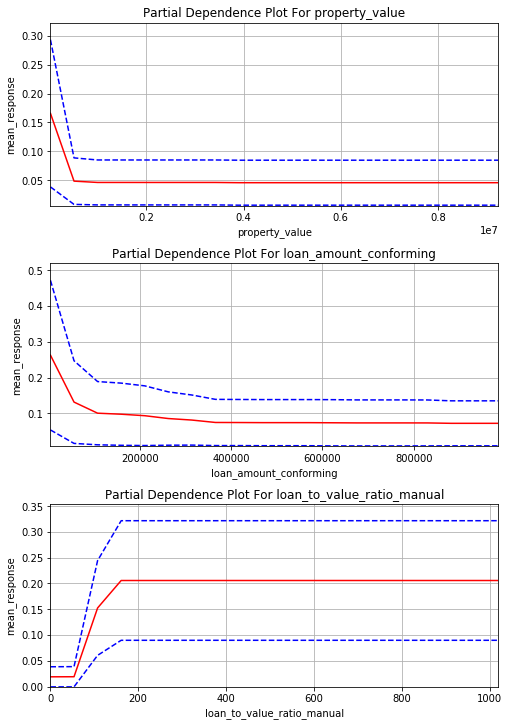

In [464]:
# PDP for constrained variables using monotonic GBM
mgbm_default.partial_plot(data=test,cols=['property_value', 'loan_amount_conforming', 'loan_to_value_ratio_manual'], 
                          server=True, plot=True)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42601 on column 'property_value'


,property_value,mean_response,stddev_response,std_error_mean_response
0,2.500000e+04,0.220647,0.070515,0.000354
1,5.102632e+05,0.054378,0.059702,0.000300
2,9.955263e+05,0.049577,0.053961,0.000271
3,1.480789e+06,0.054442,0.062148,0.000312
4,1.966053e+06,0.060245,0.065989,0.000331
5,2.451316e+06,0.060245,0.065989,0.000331
6,2.936579e+06,0.060245,0.065989,0.000331
7,3.421842e+06,0.060245,0.065989,0.000331
8,3.907105e+06,0.060245,0.065989,0.000331
9,4.392368e+06,0.060245,0.065989,0.000331



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42601 on column 'loan_amount_conforming'


,loan_amount_conforming,mean_response,stddev_response,std_error_mean_response
0,5000.000000,0.107904,0.096898,0.000487
1,56578.947368,0.105605,0.101286,0.000509
2,108157.894737,0.099013,0.094441,0.000474
3,159736.842105,0.098000,0.094056,0.000472
4,211315.789474,0.096489,0.093255,0.000468
5,262894.736842,0.090232,0.085657,0.000430
6,314473.684211,0.081467,0.079024,0.000397
7,366052.631579,0.076783,0.075512,0.000379
8,417631.578947,0.076216,0.074912,0.000376
9,469210.526316,0.076007,0.075239,0.000378



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42601 on column 'loan_to_value_ratio_manual'


,loan_to_value_ratio_manual,mean_response,stddev_response,std_error_mean_response
0,1.000000,0.045232,0.041262,0.000207
1,54.631579,0.024004,0.048948,0.000246
2,108.263158,0.110404,0.053178,0.000267
3,161.894737,0.249828,0.126152,0.000633
4,215.526316,0.261435,0.132317,0.000664
5,269.157895,0.261435,0.132317,0.000664
6,322.789474,0.261435,0.132317,0.000664
7,376.421053,0.223422,0.107225,0.000538
8,430.052632,0.223422,0.107225,0.000538
9,483.684211,0.223422,0.107225,0.000538



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42601 on column 'property_value'


,property_value,mean_response,stddev_response,std_error_mean_response
0,2.500000e+04,0.220647,0.070515,0.000354
1,5.102632e+05,0.054378,0.059702,0.000300
2,9.955263e+05,0.049577,0.053961,0.000271
3,1.480789e+06,0.054442,0.062148,0.000312
4,1.966053e+06,0.060245,0.065989,0.000331
5,2.451316e+06,0.060245,0.065989,0.000331
6,2.936579e+06,0.060245,0.065989,0.000331
7,3.421842e+06,0.060245,0.065989,0.000331
8,3.907105e+06,0.060245,0.065989,0.000331
9,4.392368e+06,0.060245,0.065989,0.000331



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42601 on column 'loan_amount_conforming'


,loan_amount_conforming,mean_response,stddev_response,std_error_mean_response
0,5000.000000,0.107904,0.096898,0.000487
1,56578.947368,0.105605,0.101286,0.000509
2,108157.894737,0.099013,0.094441,0.000474
3,159736.842105,0.098000,0.094056,0.000472
4,211315.789474,0.096489,0.093255,0.000468
5,262894.736842,0.090232,0.085657,0.000430
6,314473.684211,0.081467,0.079024,0.000397
7,366052.631579,0.076783,0.075512,0.000379
8,417631.578947,0.076216,0.074912,0.000376
9,469210.526316,0.076007,0.075239,0.000378



PartialDependence: Partial Dependence Plot of model GBM_model_python_1574453305437_42601 on column 'loan_to_value_ratio_manual'


,loan_to_value_ratio_manual,mean_response,stddev_response,std_error_mean_response
0,1.000000,0.045232,0.041262,0.000207
1,54.631579,0.024004,0.048948,0.000246
2,108.263158,0.110404,0.053178,0.000267
3,161.894737,0.249828,0.126152,0.000633
4,215.526316,0.261435,0.132317,0.000664
5,269.157895,0.261435,0.132317,0.000664
6,322.789474,0.261435,0.132317,0.000664
7,376.421053,0.223422,0.107225,0.000538
8,430.052632,0.223422,0.107225,0.000538
9,483.684211,0.223422,0.107225,0.000538


[, , ]

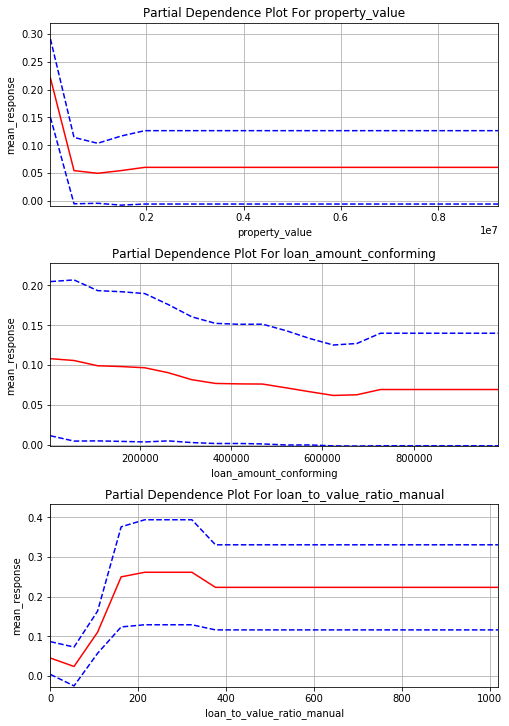

In [465]:
# PDP for same variables as above but no constrains 
gbm_default.partial_plot(data=test,cols=['property_value', 'loan_amount_conforming', 'loan_to_value_ratio_manual'],
                         server=True, plot=True)

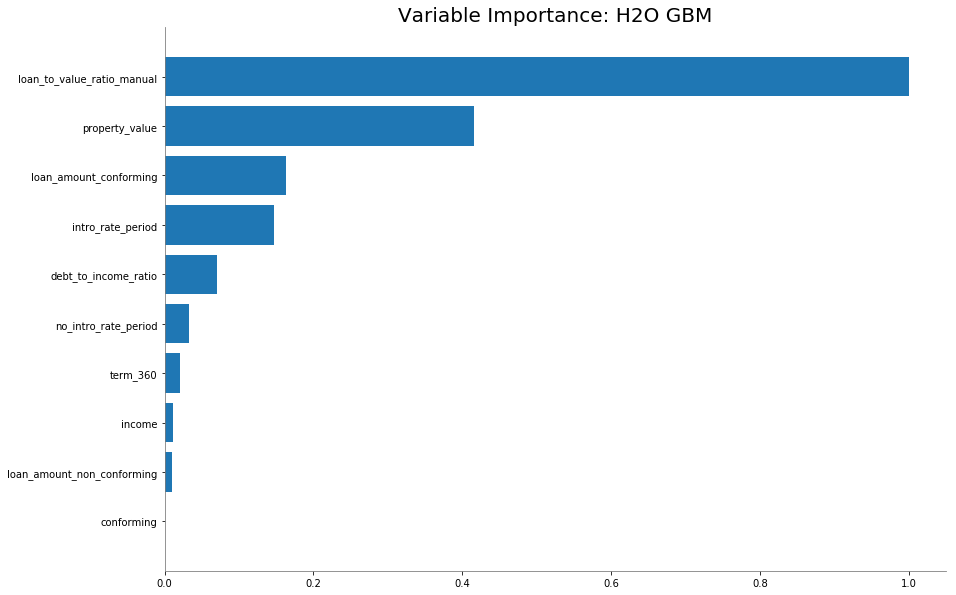

In [466]:
# MGBM var importance
mgbm_default.varimp_plot()

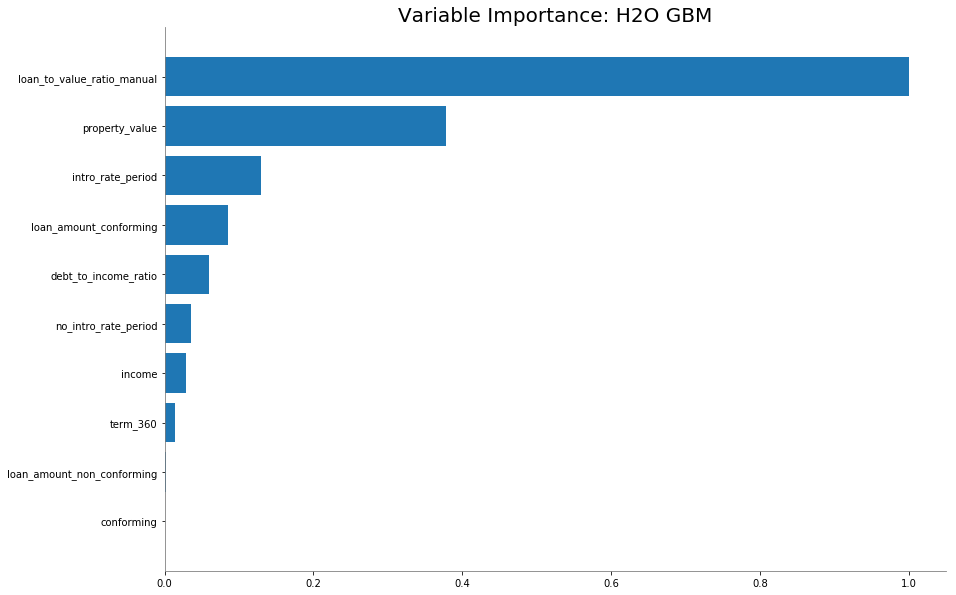

In [467]:
# GBM var importance
gbm_default.varimp_plot()

## Shapley for MGBM

In [468]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
0.00273055,0.00162731,0.355012,-0.0260076,0.219431,0.0216907,0.000346161,0.0622099,0.00916304,1.10211,-2.83589
-0.00416844,0.00638539,-0.0849295,0.0064411,-0.0772205,0.0290891,8.83e-05,-0.0588667,0.0162718,0.605376,-2.83589
-0.118003,-0.762378,0.568668,-0.0410394,-0.0323592,0.016615,0.000179928,0.115807,0.0170214,0.542727,-2.83589
-0.0152649,-0.00538399,-0.370521,0.00437946,-0.0669006,0.0333133,0.000109837,-0.0453622,0.0343331,-1.21962,-2.83589
0.00392473,0.00207079,0.433767,-0.024102,0.188586,0.0216765,0.000346161,0.0750041,0.0103233,1.09495,-2.83589


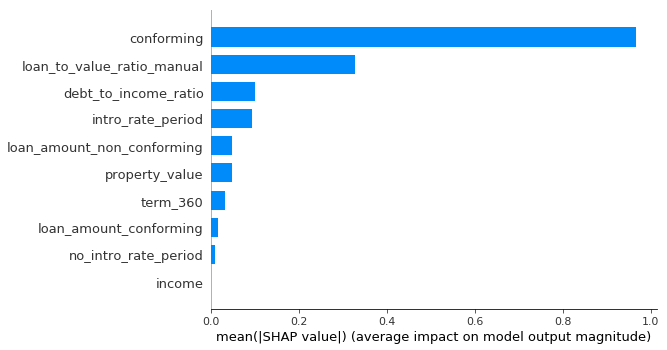

In [469]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

## Shapley for GBM

In [470]:
shap_values_gbm_default, expected_value_gbm_default = get_shapley(gbm_default, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.00845032,0.00840667,0.394041,-0.0275127,0.16803,0.0222382,0,0.097104,-0.00148163,1.22723,-2.9804
-0.0177023,0.00840181,-0.273557,0.000542701,-0.143093,0.0234107,0,0.0316126,0.000327969,0.498437,-2.9804
-0.357596,-0.432481,0.757311,-0.0115536,0.143213,0.00995941,0,0.0999021,-0.000213555,0.512092,-2.9804
-0.124687,-0.00430281,-0.500944,-0.00155896,-0.0577928,0.0176678,0,0.0259578,-0.00168392,-1.24789,-2.9804
-0.00757725,0.0122064,0.37853,0.00660085,0.171597,0.0190618,0,0.137587,-0.00048845,1.193,-2.9804


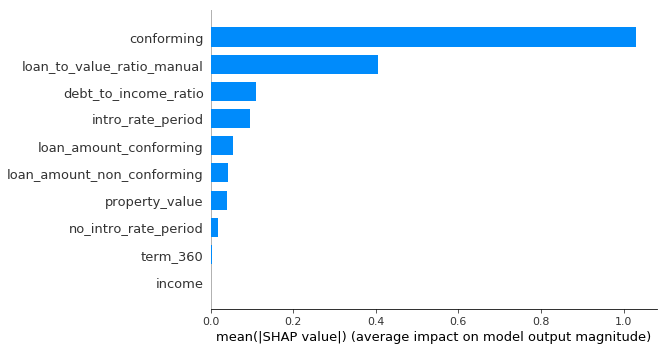

In [471]:
shap.summary_plot(shap_values_gbm_default, X, plot_type="bar")

In [472]:
# Default XGBoost with monotonic constraints
mxgb_default = H2OXGBoostEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mxgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [473]:
mxgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1574453305437_42962


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07738202724563056
RMSE: 0.27817625212377595
LogLoss: 0.2584014315941231
Mean Per-Class Error: 0.2497653135554383
AUC: 0.808232515981171
pr_auc: 0.2716380222199313
Gini: 0.6164650319623419

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1659909658441224: 


,,0,1,Error,Rate
0,0,110278.0,34555.0,0.2386,(34555.0/144833.0)
1,1,5086.0,10419.0,0.328,(5086.0/15505.0)
2,Total,115364.0,44974.0,0.2472,(39641.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.165991,0.344549,220.0
1,max f2,0.094574,0.522949,280.0
2,max f0point5,0.222719,0.291028,160.0
3,max accuracy,0.543491,0.903672,33.0
4,max precision,0.942579,1.000000,0.0
5,max recall,0.000872,1.000000,398.0
6,max specificity,0.942579,1.000000,0.0
7,max absolute_mcc,0.117294,0.300800,261.0
8,max min_per_class_accuracy,0.154174,0.729744,232.0
9,max mean_per_class_accuracy,0.093815,0.750235,281.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010016,0.387084,4.809941,4.809941,0.465131,0.473297,0.465131,0.473297,0.048178,0.048178,380.994103,380.994103
1,,2,0.020026,0.335247,3.337486,4.073943,0.322741,0.353144,0.393958,0.413239,0.033409,0.081587,233.748571,307.394265
2,,3,0.030099,0.307928,3.028679,3.724150,0.292879,0.318886,0.360133,0.381664,0.030506,0.112093,202.867941,272.414984
3,,4,0.040022,0.289276,3.106865,3.571103,0.300440,0.298501,0.345333,0.361045,0.030829,0.142922,210.686518,257.110326
4,,5,0.050250,0.273338,2.887928,3.432043,0.279268,0.280765,0.331885,0.344704,0.029539,0.172460,188.792773,243.204308
5,,6,0.100138,0.225461,2.513190,2.974276,0.243030,0.245985,0.287618,0.295523,0.125379,0.297839,151.318961,197.427596
6,,7,0.150083,0.203338,2.294711,2.748131,0.221903,0.212429,0.265750,0.267871,0.114608,0.412448,129.471130,174.813094
7,,8,0.200165,0.190588,2.109420,2.588324,0.203985,0.197610,0.250296,0.250292,0.105643,0.518091,110.941992,158.832383
8,,9,0.300010,0.159032,1.887473,2.355076,0.182522,0.175314,0.227740,0.225338,0.188455,0.706546,88.747279,135.507591
9,,10,0.399999,0.101691,1.435182,2.125128,0.138785,0.132311,0.205504,0.202084,0.143502,0.850048,43.518208,112.512756




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.07882097673769453
RMSE: 0.28075073773312603
LogLoss: 0.2643424291077819
Mean Per-Class Error: 0.258178291579636
AUC: 0.7961040205068172
pr_auc: 0.24352402798974013
Gini: 0.5922080410136343

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14875692230028412: 


,,0,1,Error,Rate
0,0,104362.0,40471.0,0.2794,(40471.0/144833.0)
1,1,4220.0,11285.0,0.2722,(4220.0/15505.0)
2,Total,108582.0,51756.0,0.2787,(44691.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.148757,0.335558,233.0
1,max f2,0.097763,0.513533,275.0
2,max f0point5,0.210218,0.273748,169.0
3,max accuracy,0.936688,0.903292,0.0
4,max precision,0.386030,0.361596,69.0
5,max recall,0.000415,1.000000,399.0
6,max specificity,0.936688,0.999993,0.0
7,max absolute_mcc,0.105170,0.290480,269.0
8,max min_per_class_accuracy,0.149966,0.722715,232.0
9,max mean_per_class_accuracy,0.087070,0.741822,285.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.384167,3.745730,3.745730,0.362219,0.473385,0.362219,0.473385,0.037472,0.037472,274.572992,274.572992
1,,2,0.020001,0.329810,3.044901,3.395425,0.294448,0.351675,0.328344,0.412549,0.030442,0.067914,204.490094,239.542469
2,,3,0.030005,0.307474,2.907615,3.232788,0.281172,0.317688,0.312617,0.380922,0.029087,0.097001,190.761479,223.278759
3,,4,0.040003,0.290097,2.890075,3.147136,0.279476,0.298347,0.304334,0.360285,0.028894,0.125895,189.007547,214.713628
4,,5,0.050007,0.273996,2.817356,3.081164,0.272444,0.282445,0.297955,0.344713,0.028184,0.154079,181.735624,208.116382
5,,6,0.100001,0.224313,2.501409,2.791323,0.241891,0.245553,0.269926,0.295139,0.125056,0.279136,150.140948,179.132281
6,,7,0.150002,0.201221,2.258598,2.613748,0.218411,0.211373,0.252755,0.267217,0.112931,0.392067,125.859808,161.374790
7,,8,0.200002,0.189524,2.045766,2.471752,0.197830,0.195865,0.239023,0.249379,0.102290,0.494357,104.576616,147.175246
8,,9,0.300010,0.157978,1.928266,2.290583,0.186467,0.174522,0.221504,0.224426,0.192841,0.687198,92.826588,129.058274
9,,10,0.399999,0.100838,1.475819,2.086914,0.142715,0.131588,0.201809,0.201219,0.147565,0.834763,47.581869,108.691396




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7363443,0.015976327,0.72381014,0.7630421,0.734257,0.7242309,0.7363814
1,auc,0.7962203,0.0039351606,0.79234844,0.80205315,0.7945433,0.7983228,0.7938337
2,err,0.2636557,0.015976327,0.2761899,0.2369579,0.265743,0.2757691,0.2636186
3,err_count,8456.4,543.92676,8832.0,7540.0,8516.0,8901.0,8493.0
4,f0point5,0.25774232,0.009640752,0.2510997,0.2735388,0.25222942,0.25138846,0.26045513
5,f1,0.33669624,0.0067290813,0.33171913,0.34707308,0.33134422,0.33350804,0.33983678
6,f2,0.4860329,0.0077435677,0.48858774,0.47467905,0.48277125,0.49530715,0.48881933
7,lift_top_group,3.6989076,0.22459503,3.3180299,3.8377197,3.7753403,3.8762648,3.6871831
8,logloss,0.2643519,0.0041562878,0.2652393,0.2680386,0.26146522,0.2587667,0.26824963
9,max_per_class_error,0.3098507,0.036859453,0.28645834,0.3711955,0.30569267,0.2765863,0.3093207



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-03 10:28:54,30.766 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-12-03 10:28:55,31.117 sec,1.0,0.405609,0.518516,0.774416,0.237525,3.477448,0.270073
2,,2019-12-03 10:28:55,31.356 sec,2.0,0.351278,0.424788,0.776628,0.236643,3.813156,0.260263
3,,2019-12-03 10:28:55,31.596 sec,3.0,0.320077,0.368718,0.777159,0.237908,3.914553,0.267048
4,,2019-12-03 10:28:55,31.838 sec,4.0,0.302689,0.333892,0.779764,0.239064,3.951092,0.289975
5,,2019-12-03 10:28:56,32.081 sec,5.0,0.292930,0.311086,0.780195,0.239316,3.899188,0.262545
6,,2019-12-03 10:28:56,32.330 sec,6.0,0.287750,0.296531,0.781008,0.239796,3.873239,0.278262
7,,2019-12-03 10:28:56,32.585 sec,7.0,0.284967,0.287024,0.781758,0.239955,3.947701,0.274489
8,,2019-12-03 10:28:56,32.830 sec,8.0,0.283427,0.280669,0.782218,0.240791,3.910137,0.276871
9,,2019-12-03 10:28:57,33.083 sec,9.0,0.282579,0.276431,0.782743,0.241643,3.941944,0.273167



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,15877.023438,1.000000,0.483440
1,property_value,6100.375977,0.384227,0.185751
2,loan_amount_conforming,2478.893311,0.156131,0.075480
3,intro_rate_period,2458.005127,0.154815,0.074844
4,income,1964.408203,0.123726,0.059814
5,no_intro_rate_period,1801.335205,0.113455,0.054849
6,debt_to_income_ratio,1477.881714,0.093083,0.045000
7,loan_amount_non_conforming,377.223267,0.023759,0.011486
8,term_360,306.605957,0.019311,0.009336


In [474]:
# Get the AUC on the test set for MXGB
perf_mxgb_default = mxgb_default.model_performance(test)
print(perf_mxgb_default.auc())

0.7994703360878251


In [475]:
# Get the AUC on 5 fold CV for the default MXGB
perf_cv_mxgb_default = mxgb_default.model_performance(xval=True)
print(perf_cv_mxgb_default.auc())

0.7961040205068172


In [476]:
# Default XGBoost
xgb_default = H2OXGBoostEstimator(
               seed=SEED)
xgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [477]:
xgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1574453305437_43158


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07498167210752375
RMSE: 0.27382781470757084
LogLoss: 0.2481493478464515
Mean Per-Class Error: 0.23066992102657036
AUC: 0.830194812122384
pr_auc: 0.3180163457529708
Gini: 0.660389624244768

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18467707030631444: 


,,0,1,Error,Rate
0,0,112738.0,32095.0,0.2216,(32095.0/144833.0)
1,1,4700.0,10805.0,0.3031,(4700.0/15505.0)
2,Total,117438.0,42900.0,0.2295,(36795.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.184677,0.370003,205.0
1,max f2,0.133818,0.545793,248.0
2,max f0point5,0.239183,0.318740,145.0
3,max accuracy,0.418835,0.905356,61.0
4,max precision,0.951518,1.000000,0.0
5,max recall,0.003386,1.000000,392.0
6,max specificity,0.951518,1.000000,0.0
7,max absolute_mcc,0.151105,0.329552,235.0
8,max min_per_class_accuracy,0.172618,0.749663,217.0
9,max mean_per_class_accuracy,0.098752,0.769330,275.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.360647,6.002194,6.002194,0.580424,0.467064,0.580424,0.467064,0.060045,0.060045,500.219373,500.219373
1,,2,0.020008,0.313984,3.655471,4.828833,0.353491,0.331630,0.466958,0.399347,0.036569,0.096614,265.547137,382.883255
2,,3,0.030018,0.297521,3.363258,4.340105,0.325234,0.305279,0.419697,0.367978,0.033667,0.130281,236.325780,334.010463
3,,4,0.040259,0.286611,2.978878,3.993841,0.288063,0.291719,0.386212,0.348580,0.030506,0.160787,197.887774,299.384056
4,,5,0.050001,0.273934,2.959315,3.792278,0.286172,0.280233,0.366721,0.335263,0.028829,0.189616,195.931493,279.227775
5,,6,0.100213,0.236238,2.738433,3.264240,0.264812,0.254310,0.315658,0.294701,0.137504,0.327120,173.843266,226.424023
6,,7,0.151424,0.213857,2.421854,2.979351,0.234198,0.224050,0.288109,0.270807,0.124025,0.451145,142.185381,197.935062
7,,8,0.200034,0.201132,2.274129,2.807976,0.219913,0.207309,0.271537,0.255377,0.110545,0.561690,127.412906,180.797604
8,,9,0.300191,0.171662,1.927316,2.514148,0.186375,0.188431,0.243123,0.233041,0.193035,0.754724,92.731593,151.414822
9,,10,0.399999,0.095546,1.319529,2.216066,0.127601,0.138126,0.214298,0.209358,0.131699,0.886424,31.952926,121.606625




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.0771235118422723
RMSE: 0.2777112022268319
LogLoss: 0.25754494867031774
Mean Per-Class Error: 0.24337784820495356
AUC: 0.8099958405318611
pr_auc: 0.27012592135588165
Gini: 0.6199916810637223

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17224479637790524: 


,,0,1,Error,Rate
0,0,108160.0,36673.0,0.2532,(36673.0/144833.0)
1,1,4281.0,11224.0,0.2761,(4281.0/15505.0)
2,Total,112441.0,47897.0,0.2554,(40954.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.172245,0.354058,217.0
1,max f2,0.107186,0.530401,270.0
2,max f0point5,0.224448,0.288409,159.0
3,max accuracy,0.643406,0.903797,23.0
4,max precision,0.884891,1.000000,0.0
5,max recall,0.000596,1.000000,399.0
6,max specificity,0.884891,1.000000,0.0
7,max absolute_mcc,0.129740,0.311937,253.0
8,max min_per_class_accuracy,0.167366,0.738257,222.0
9,max mean_per_class_accuracy,0.093085,0.756622,281.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.354515,4.480692,4.480692,0.433292,0.460284,0.433292,0.460284,0.044824,0.044824,348.069242,348.069242
1,,2,0.020095,0.315833,3.310670,3.893139,0.320148,0.331346,0.376474,0.395535,0.033409,0.078233,231.067031,289.313941
2,,3,0.030005,0.297823,2.713794,3.503620,0.262429,0.306413,0.338807,0.366099,0.026895,0.105127,171.379382,250.361953
3,,4,0.040047,0.285564,3.076623,3.396555,0.297516,0.291380,0.328454,0.347364,0.030893,0.136021,207.662333,239.655461
4,,5,0.050007,0.273276,2.739051,3.265595,0.264872,0.279224,0.315789,0.333792,0.027282,0.163302,173.905115,226.559514
5,,6,0.100014,0.234404,2.603964,2.934780,0.251808,0.251916,0.283799,0.292854,0.130216,0.293518,160.396390,193.477952
6,,7,0.150002,0.214661,2.346896,2.738867,0.226949,0.222941,0.264854,0.269555,0.117317,0.410835,134.689610,173.886727
7,,8,0.200009,0.202715,2.173194,2.597436,0.210152,0.208759,0.251177,0.254355,0.108675,0.519510,117.319424,159.743578
8,,9,0.300004,0.171021,2.067178,2.420694,0.199900,0.188722,0.234086,0.232479,0.206708,0.726217,106.717828,142.069430
9,,10,0.400030,0.096935,1.368877,2.157691,0.132373,0.137238,0.208653,0.208664,0.136924,0.863141,36.887716,115.769082




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.74855876,0.0031692318,0.745794,0.74701446,0.75322974,0.7504105,0.7463451
1,auc,0.81015337,0.004257297,0.80818796,0.8164121,0.80609137,0.8125811,0.8074944
2,err,0.25144124,0.0031692318,0.254206,0.25298554,0.24677026,0.24958949,0.2536549
3,err_count,8063.0,100.59821,8129.0,8050.0,7908.0,8056.0,8172.0
4,f0point5,0.2720967,0.007010124,0.26999024,0.28341743,0.2652435,0.2682499,0.2735824
5,f1,0.35427547,0.0089957565,0.3527351,0.3684293,0.34416986,0.3502178,0.3558253
6,f2,0.5075914,0.012976391,0.5086108,0.5262922,0.48996457,0.50432074,0.50876874
7,lift_top_group,4.438586,0.121063046,4.489099,4.4131284,4.303377,4.3690104,4.6183167
8,logloss,0.2575543,0.004107817,0.2575825,0.26104456,0.25604442,0.2514994,0.26160058
9,max_per_class_error,0.2865301,0.019622533,0.27897134,0.26325697,0.3172096,0.2863248,0.28688782



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-03 10:29:50,29.717 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-12-03 10:29:50,30.055 sec,1.0,0.404856,0.517174,0.799330,0.259934,4.366081,0.299000
2,,2019-12-03 10:29:50,30.274 sec,2.0,0.349627,0.421889,0.801835,0.265828,4.417536,0.290542
3,,2019-12-03 10:29:51,30.483 sec,3.0,0.317740,0.364454,0.802519,0.268854,4.734982,0.289644
4,,2019-12-03 10:29:51,30.695 sec,4.0,0.299701,0.328077,0.804102,0.270821,4.792499,0.274476
5,,2019-12-03 10:29:51,30.926 sec,5.0,0.289629,0.304244,0.806098,0.272992,4.785222,0.264641
6,,2019-12-03 10:29:51,31.169 sec,6.0,0.284131,0.288518,0.806813,0.273537,4.826253,0.265545
7,,2019-12-03 10:29:52,31.404 sec,7.0,0.281080,0.277999,0.808117,0.275627,4.839199,0.262383
8,,2019-12-03 10:29:52,31.651 sec,8.0,0.279348,0.270844,0.809069,0.278115,4.929967,0.259483
9,,2019-12-03 10:29:52,31.895 sec,9.0,0.278303,0.265855,0.810619,0.280476,4.905297,0.254749



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,21344.281250,1.000000,0.557773
1,property_value,6354.751465,0.297726,0.166064
2,intro_rate_period,2729.404785,0.127875,0.071325
3,income,2546.451416,0.119304,0.066544
4,loan_amount_conforming,2070.677490,0.097013,0.054111
5,debt_to_income_ratio,1626.054199,0.076182,0.042492
6,no_intro_rate_period,1013.679810,0.047492,0.026490
7,term_360,306.261200,0.014349,0.008003
8,loan_amount_non_conforming,275.420166,0.012904,0.007197


In [478]:
# Get the AUC on the test set for the default GBM
perf_xgb_default = xgb_default.model_performance(test)
print(perf_xgb_default.auc())

0.8118406629536278


In [479]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_xgb_default = xgb_default.model_performance(xval=True)
print(perf_cv_xgb_default.auc())

0.8099958405318611


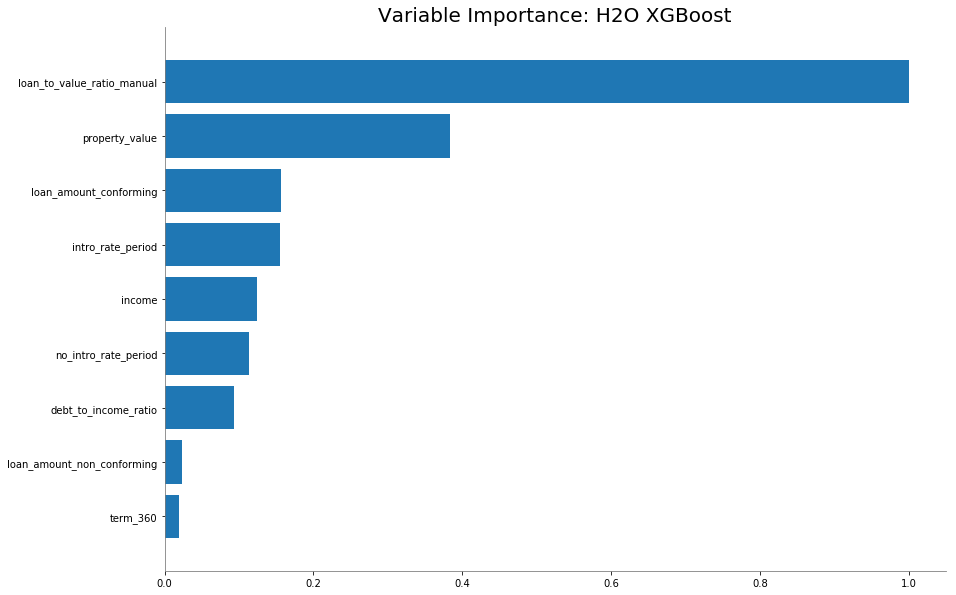

In [480]:
# MXGB var importance
mxgb_default.varimp_plot()

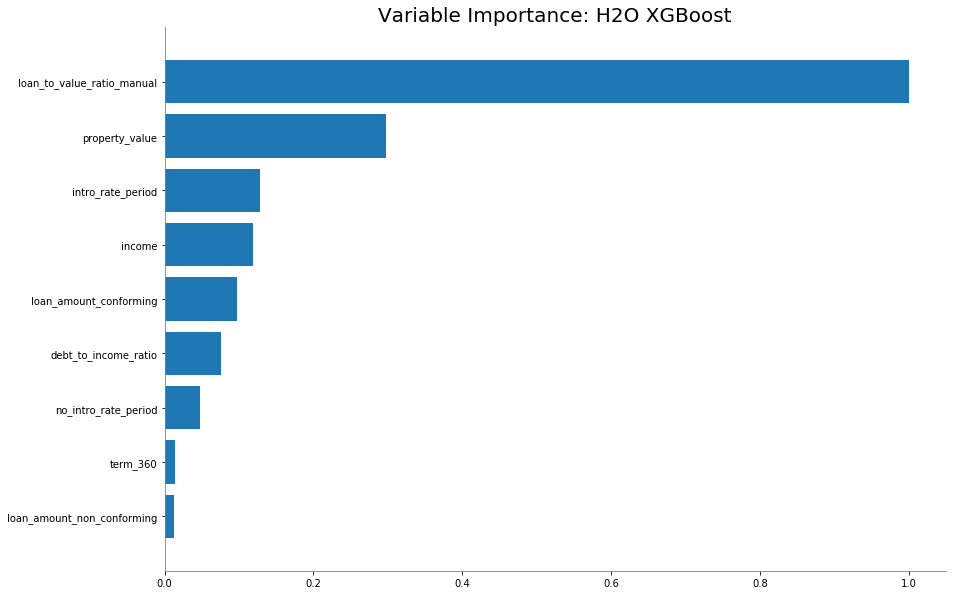

In [481]:
# XGB var importance
xgb_default.varimp_plot()

## Shapey for MXGB

In [482]:
shap_values_mxgb_default, expected_value_mxgb_default = get_shapley(mxgb_default, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.00930465,-0.0123813,0.248827,-0.321049,0.0659561,0.0163076,0,0.0129329,0.00285923,0.693192,-2.34124
-0.0131692,-0.011003,-0.283313,-0.0778434,-0.148493,0.0213461,0,-0.119896,0.00339233,0.208437,-2.34124
-0.0561851,-0.746734,0.505229,0.143106,0.0978285,-0.00605887,0,0.249357,0.0315126,0.419315,-2.34124
-0.0786271,-0.0171469,-0.448513,-0.0246801,-0.105672,0.0176538,0,-0.254953,0.00409433,-2.26628,-2.34124
-0.00751913,-0.00516843,0.280881,-0.0913537,0.15152,0.0166507,0,0.0433297,0.00419523,0.770202,-2.34124


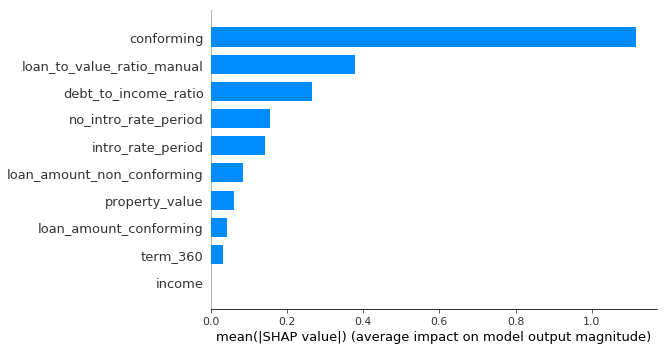

In [483]:
shap.summary_plot(shap_values_mxgb_default, X, plot_type="bar")

## Shapley for XGB

In [484]:
shap_values_xgb_default, expected_value_xgb_default = get_shapley(xgb_default, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.0184798,0.00166175,0.176902,-0.377743,0.0289731,0.0100238,0,0.109529,0.00307945,0.70184,-2.35977
-0.0220951,-0.00329182,-0.436832,-0.137403,-0.248642,0.0178275,0,-0.0243018,0.00293616,0.0887115,-2.35977
-0.76952,-0.695166,0.338486,-0.0432226,-0.150952,-0.000129292,0,0.0383829,0.00316587,0.316657,-2.35977
-0.256807,-0.0727495,-0.550056,-0.03221,-0.0978173,0.0229899,0,-0.119316,0.000746431,-1.95416,-2.35977
-0.0149527,0.0046197,0.230619,-0.0409016,0.168949,0.0112075,0,0.162426,0.00238691,0.758225,-2.35977


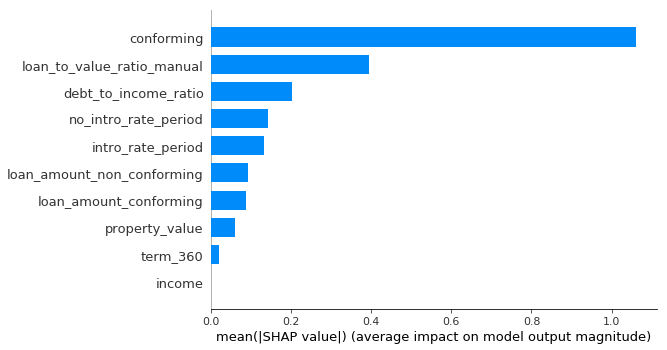

In [485]:
shap.summary_plot(shap_values_xgb_default, X, plot_type="bar")

In [486]:
mgbm_lucky = H2OGradientBoostingEstimator(
  # monotonicity constraints
  monotone_constraints=mono_constraints,
    
  # more trees is better if the learning rate is small enough 
  # here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            

  # smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  # early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  # sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  # sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  # fix a random number generator seed for reproducibility
  seed = SEED,                                                             

  # score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

mgbm_lucky.train(x=X, y=Y, training_frame=train, fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [487]:
mgbm_lucky

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_43353


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,518.0,518.0,165140.0,5.0,5.0,5.0,8.0,32.0,20.698841




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07926985985805152
RMSE: 0.281549036329467
LogLoss: 0.267289911737631
Mean Per-Class Error: 0.2646209755935631
AUC: 0.789331716015474
pr_auc: 0.2370896645575198
Gini: 0.578663432030948

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15626798931200025: 


,,0,1,Error,Rate
0,0,109407.0,35426.0,0.2446,(35426.0/144833.0)
1,1,5530.0,9975.0,0.3567,(5530.0/15505.0)
2,Total,114937.0,45401.0,0.2554,(40956.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.156268,0.327554,211.0
1,max f2,0.108240,0.507077,258.0
2,max f0point5,0.206665,0.265761,155.0
3,max accuracy,0.888451,0.903304,0.0
4,max precision,0.888451,1.000000,0.0
5,max recall,0.004444,1.000000,399.0
6,max specificity,0.888451,1.000000,0.0
7,max absolute_mcc,0.110128,0.284844,256.0
8,max min_per_class_accuracy,0.136378,0.715341,229.0
9,max mean_per_class_accuracy,0.104167,0.735379,262.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.373667,3.694154,3.694154,0.357232,0.443698,0.357232,0.443698,0.036956,0.036956,269.415360,269.415360
1,,2,0.020001,0.328438,2.967488,3.330934,0.286962,0.351978,0.322108,0.397852,0.029668,0.066624,196.748820,233.093420
2,,3,0.030012,0.278331,2.989562,3.217073,0.289097,0.299887,0.311097,0.365177,0.029926,0.096550,198.956249,221.707268
3,,4,0.040047,0.270860,2.545094,3.048686,0.246116,0.274599,0.294814,0.342479,0.025540,0.122090,154.509404,204.868557
4,,5,0.050001,0.260555,2.669494,2.973197,0.258145,0.264607,0.287514,0.326977,0.026572,0.148662,166.949444,197.319735
5,,6,0.100132,0.215590,2.428951,2.700718,0.234884,0.231769,0.261165,0.279311,0.121767,0.270429,142.895059,170.071803
6,,7,0.150919,0.197989,2.190632,2.529066,0.211838,0.206812,0.244566,0.254914,0.111254,0.381683,119.063164,152.906610
7,,8,0.200233,0.178989,2.096459,2.422521,0.202732,0.190046,0.234263,0.238938,0.103386,0.485069,109.645949,142.252131
8,,9,0.300029,0.147694,1.850286,2.232185,0.178926,0.164519,0.215857,0.214185,0.184650,0.669719,85.028622,123.218468
9,,10,0.400024,0.104398,1.553770,2.062599,0.150253,0.126639,0.199457,0.192301,0.155369,0.825089,55.376988,106.259949




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07979457486402754
RMSE: 0.28247933528672065
LogLoss: 0.2715462837347607
Mean Per-Class Error: 0.2711133393047531
AUC: 0.781045002907896
pr_auc: 0.231369304597268
Gini: 0.562090005815792

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13611622475124072: 


,,0,1,Error,Rate
0,0,104591.0,40242.0,0.2779,(40242.0/144833.0)
1,1,4747.0,10758.0,0.3062,(4747.0/15505.0)
2,Total,109338.0,51000.0,0.2806,(44989.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.136116,0.323525,224.0
1,max f2,0.091738,0.499464,269.0
2,max f0point5,0.208839,0.261515,144.0
3,max accuracy,0.854046,0.903292,0.0
4,max precision,0.418107,0.354376,44.0
5,max recall,0.002705,1.000000,399.0
6,max specificity,0.854046,0.999986,0.0
7,max absolute_mcc,0.102048,0.275532,258.0
8,max min_per_class_accuracy,0.132638,0.709642,228.0
9,max mean_per_class_accuracy,0.091738,0.728887,269.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.355400,3.378249,3.378249,0.326683,0.429892,0.326683,0.429892,0.033796,0.033796,237.824867,237.824867
1,,2,0.020001,0.297518,3.219080,3.298689,0.311291,0.327935,0.318990,0.378929,0.032183,0.065979,221.907959,229.868895
2,,3,0.030018,0.275290,2.820287,3.139056,0.272727,0.284452,0.303553,0.347404,0.028249,0.094228,182.028671,213.905587
3,,4,0.040053,0.258547,2.737904,3.038549,0.264761,0.267431,0.293834,0.327367,0.027475,0.121703,173.790419,203.854932
4,,5,0.050069,0.241884,2.446824,2.920175,0.236613,0.249715,0.282387,0.311833,0.024508,0.146211,144.682409,192.017479
5,,6,0.100007,0.210120,2.435772,2.678290,0.235544,0.223084,0.258996,0.267517,0.121638,0.267849,143.577154,167.829036
6,,7,0.150002,0.189333,2.150516,2.502387,0.207959,0.198587,0.241986,0.244543,0.107514,0.375363,115.051553,150.238736
7,,8,0.200002,0.174706,2.045766,2.388232,0.197830,0.181750,0.230947,0.228845,0.102290,0.477652,104.576616,138.823206
8,,9,0.300047,0.143269,1.843094,2.206466,0.178231,0.159980,0.213370,0.205883,0.184392,0.662045,84.309367,120.646639
9,,10,0.400074,0.101299,1.503637,2.030745,0.145405,0.123096,0.196377,0.185185,0.150403,0.812448,50.363709,103.074536




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7245585,0.021124551,0.7477328,0.72209305,0.739125,0.7211947,0.69264674
1,auc,0.7817963,0.010468568,0.76890975,0.79397064,0.78674775,0.77294666,0.78640646
2,err,0.27544156,0.021124551,0.25226718,0.27790698,0.260875,0.27880535,0.30735326
3,err_count,8834.2,703.7213,8067.0,8843.0,8360.0,8999.0,9902.0
4,f0point5,0.2467881,0.008080989,0.24533573,0.25859132,0.24837103,0.23602168,0.24562076
5,f1,0.3243063,0.011231047,0.3158341,0.33992684,0.3241714,0.31173995,0.32985923
6,f2,0.47333604,0.024970356,0.4431856,0.49590558,0.46656117,0.45898834,0.5020395
7,lift_top_group,3.6369638,0.21221776,3.7734456,3.4417968,3.7777736,3.8197634,3.3720393
8,logloss,0.271548,0.004496947,0.27730548,0.27187383,0.2647354,0.27260464,0.2712207
9,max_per_class_error,0.33309665,0.03973994,0.39388022,0.28553498,0.3402435,0.33004603,0.3157786



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-03 10:33:06,2 min 1.466 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-12-03 10:33:07,2 min 1.791 sec,10.0,0.293500,0.310997,0.768753,0.227542,3.744497,0.292083
2,,2019-12-03 10:33:07,2 min 2.145 sec,20.0,0.291872,0.305786,0.769945,0.228447,3.781942,0.293143
3,,2019-12-03 10:33:07,2 min 2.511 sec,30.0,0.290516,0.301543,0.768350,0.227759,3.781336,0.259078
4,,2019-12-03 10:33:08,2 min 2.880 sec,40.0,0.289362,0.297929,0.767416,0.227400,3.717651,0.255030
5,,2019-12-03 10:33:08,2 min 3.257 sec,50.0,0.288402,0.294891,0.769797,0.228988,3.782054,0.235322
6,,2019-12-03 10:33:09,2 min 3.620 sec,60.0,0.287580,0.292263,0.770671,0.230019,3.774914,0.230881
7,,2019-12-03 10:33:09,2 min 3.984 sec,70.0,0.286855,0.289876,0.771754,0.230444,3.785335,0.258947
8,,2019-12-03 10:33:09,2 min 4.365 sec,80.0,0.286245,0.287848,0.772068,0.230920,3.810200,0.257743
9,,2019-12-03 10:33:10,2 min 4.742 sec,90.0,0.285761,0.286204,0.772466,0.231129,3.810200,0.259383



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,34416.078125,1.000000,0.544408
1,property_value,13462.315430,0.391164,0.212953
2,loan_amount_conforming,5871.465820,0.170602,0.092877
3,intro_rate_period,5095.497070,0.148056,0.080603
4,debt_to_income_ratio,2224.678955,0.064641,0.035191
5,no_intro_rate_period,699.988586,0.020339,0.011073
6,term_360,607.993103,0.017666,0.009617
7,income,512.327393,0.014886,0.008104
8,loan_amount_non_conforming,305.888214,0.008888,0.004839
9,conforming,21.160988,0.000615,0.000335


In [488]:
## Get the AUC on the test set
perf_mgbm_lucky = mgbm_lucky.model_performance(test)
print(perf_mgbm_lucky.auc())

0.789830050722857


In [489]:
## Get the AUC on the test set
perf_cv_mgbm_lucky = mgbm_lucky.model_performance(xval=True)
print(perf_cv_mgbm_lucky.auc())

0.781045002907896


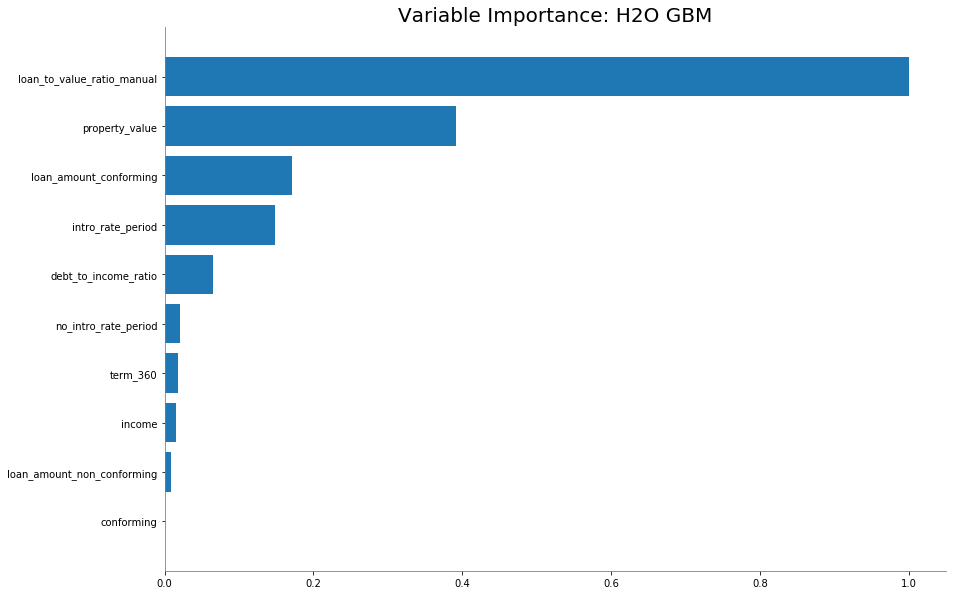

In [490]:
mgbm_lucky.varimp_plot()

In [491]:
shap_values_mgbm_lucky, expected_value_mgbm_lucky = get_shapley(mgbm_lucky, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.00113587,0.0020545,0.377634,-0.02153,0.186006,0.0168985,0.000195011,0.0770556,0.00404051,0.950133,-2.7047
-0.00937773,-0.00441957,-0.108821,0.00479336,-0.0884992,0.0216079,0.00063204,-0.046474,0.00797271,0.492602,-2.7047
-0.137227,-0.696495,0.546673,-0.00214862,-0.0421759,0.00846852,0.000275847,0.148834,0.00992372,0.46877,-2.7047
-0.0292433,-0.0366722,-0.408473,0.00532029,-0.0877925,0.0197286,0.000629021,-0.0784086,0.0143102,-1.19981,-2.7047
0.000300312,0.00672394,0.443744,-0.0193007,0.163852,0.0169979,0.000212593,0.113272,0.00462819,0.932544,-2.7047


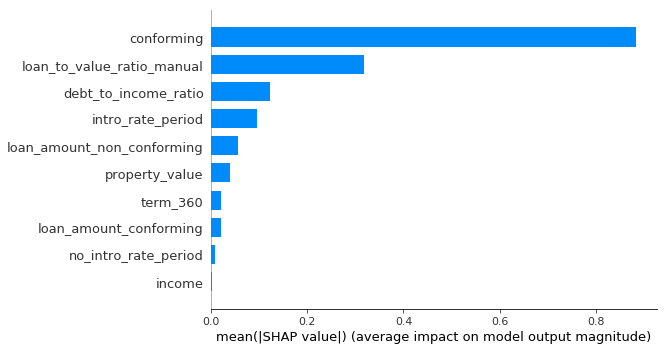

In [492]:
shap.summary_plot(shap_values_mgbm_lucky, X, plot_type="bar")

In [493]:
mxgb_lucky = H2OXGBoostEstimator(
  # monotonicity constraints
  monotone_constraints=mono_constraints,
    
  # more trees is better if the learning rate is small enough 
  # here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            

  # smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  # early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  # sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  # sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  # fix a random number generator seed for reproducibility
  seed = SEED,                                                             

  # score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

mxgb_lucky.train(x=X, y=Y, training_frame=train, fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [494]:
mxgb_lucky

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1574453305437_43952


Model Summary: 


,,number_of_trees
0,,844.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07782497887240584
RMSE: 0.2789712868243
LogLoss: 0.2604252590171782
Mean Per-Class Error: 0.25351295553991837
AUC: 0.8044353074077134
pr_auc: 0.2614144861297362
Gini: 0.6088706148154268

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1731711009170039: 


,,0,1,Error,Rate
0,0,112897.0,31936.0,0.2205,(31936.0/144833.0)
1,1,5724.0,9781.0,0.3692,(5724.0/15505.0)
2,Total,118621.0,41717.0,0.2349,(37660.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.173171,0.341862,201.0
1,max f2,0.096220,0.518599,275.0
2,max f0point5,0.206132,0.285548,160.0
3,max accuracy,0.564744,0.903329,15.0
4,max precision,0.830764,1.000000,0.0
5,max recall,0.001273,1.000000,399.0
6,max specificity,0.830764,1.000000,0.0
7,max absolute_mcc,0.120327,0.296488,254.0
8,max min_per_class_accuracy,0.153732,0.727056,223.0
9,max mean_per_class_accuracy,0.087767,0.746487,284.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010023,0.362036,4.472328,4.472328,0.432483,0.433796,0.432483,0.433796,0.044824,0.044824,347.232771,347.232771
1,,2,0.020001,0.316071,3.238042,3.856532,0.313125,0.334123,0.372934,0.384068,0.032312,0.077136,223.804168,285.653175
2,,3,0.030005,0.294080,2.926956,3.546609,0.283042,0.303605,0.342964,0.357242,0.029281,0.106417,192.695591,254.660873
3,,4,0.040022,0.280554,3.039213,3.419621,0.293898,0.287949,0.330684,0.339900,0.030442,0.136859,203.921308,241.962144
4,,5,0.050007,0.266421,2.777422,3.291390,0.268582,0.273685,0.318284,0.326678,0.027733,0.164592,177.742164,229.138973
5,,6,0.100001,0.220375,2.550431,2.920957,0.246632,0.240333,0.282462,0.283511,0.127507,0.292099,155.043143,192.095679
6,,7,0.150014,0.198455,2.325092,2.722302,0.224841,0.207100,0.263252,0.258036,0.116285,0.408384,132.509234,172.230228
7,,8,0.200027,0.190363,2.072337,2.559791,0.200399,0.194778,0.247537,0.242220,0.103644,0.512028,107.233687,155.979066
8,,9,0.300041,0.159387,1.876556,2.332046,0.181467,0.175729,0.225513,0.220056,0.187681,0.699710,87.655645,133.204592
9,,10,0.399999,0.105937,1.427887,2.106101,0.138079,0.135089,0.203664,0.198823,0.142728,0.842438,42.788709,110.610138




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.08341810683967847
RMSE: 0.28882192929152467
LogLoss: 0.2845027445847033
Mean Per-Class Error: 0.3054438523534939
AUC: 0.7435355013387713
pr_auc: 0.20988952873045444
Gini: 0.48707100267754266

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20559925127624049: 


,,0,1,Error,Rate
0,0,116112.0,28721.0,0.1983,(28721.0/144833.0)
1,1,8105.0,7400.0,0.5227,(8105.0/15505.0)
2,Total,124217.0,36121.0,0.2297,(36826.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.205599,0.286677,181.0
1,max f2,0.086886,0.465239,296.0
2,max f0point5,0.268752,0.243514,128.0
3,max accuracy,0.910238,0.903292,0.0
4,max precision,0.415442,0.379388,48.0
5,max recall,0.001085,1.000000,399.0
6,max specificity,0.910238,0.999993,0.0
7,max absolute_mcc,0.086886,0.231071,296.0
8,max min_per_class_accuracy,0.182191,0.644149,211.0
9,max mean_per_class_accuracy,0.086886,0.694556,296.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score: 12.61 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.373203,3.765071,3.765071,0.364090,0.442149,0.364090,0.442149,0.037665,0.037665,276.507104,276.507104
1,,2,0.020033,0.341273,3.131898,3.448090,0.302861,0.352469,0.333437,0.397253,0.031409,0.069074,213.189799,244.809026
2,,3,0.030074,0.327038,2.524244,3.139631,0.244099,0.335404,0.303608,0.376603,0.025347,0.094421,152.424419,213.963066
3,,4,0.040009,0.312531,2.538199,2.990281,0.245449,0.318095,0.289166,0.362074,0.025218,0.119639,153.819903,199.028061
4,,5,0.050942,0.307360,2.141359,2.808087,0.207074,0.308744,0.271548,0.350628,0.023412,0.143051,114.135859,180.808665
5,,6,0.100051,0.276099,2.138079,2.479222,0.206756,0.292973,0.239746,0.322329,0.104998,0.248049,113.807867,147.922224
6,,7,0.150226,0.243574,1.791849,2.249641,0.173275,0.257427,0.217545,0.300652,0.089906,0.337955,79.184903,124.964125
7,,8,0.200002,0.216768,1.772530,2.130899,0.171407,0.230167,0.206062,0.283110,0.088230,0.426185,77.252953,113.089893
8,,9,0.300010,0.192458,1.518751,1.926841,0.146866,0.201547,0.186329,0.255921,0.151886,0.578072,51.875122,92.684121
9,,10,0.399999,0.175400,1.003015,1.695910,0.096994,0.186294,0.163998,0.238516,0.100290,0.678362,0.301489,69.590984




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7377504,0.013464279,0.7322847,0.71961033,0.7540411,0.73532236,0.74749357
1,auc,0.7937065,0.009463262,0.77768403,0.8019818,0.7949194,0.79923135,0.79471576
2,err,0.2622496,0.013464279,0.2677153,0.2803897,0.24595894,0.26467764,0.25250643
3,err_count,8408.6,405.28793,8561.0,8922.0,7882.0,8543.0,8135.0
4,f0point5,0.25563136,0.008293241,0.24261758,0.2632745,0.2557275,0.2541811,0.26235616
5,f1,0.33349675,0.011396182,0.3168143,0.34761626,0.32987586,0.33439812,0.33877915
6,f2,0.47981083,0.021582717,0.45638478,0.51146877,0.46458164,0.48859343,0.4780255
7,lift_top_group,3.7931514,0.16579232,3.5457377,3.7871525,4.0077252,3.843415,3.7817264
8,logloss,0.2845707,0.046981428,0.36828405,0.26779374,0.2609821,0.25822306,0.26757047
9,max_per_class_error,0.3269748,0.035685405,0.35384116,0.28330946,0.3616321,0.29454306,0.34154817



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-03 11:17:22,28 min 55.988 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-12-03 11:17:24,28 min 57.456 sec,10.0,0.467935,0.630929,0.779451,0.237156,3.881891,0.284730
2,,2019-12-03 11:17:25,28 min 58.803 sec,20.0,0.440050,0.579500,0.779992,0.238517,3.941442,0.282846
3,,2019-12-03 11:17:27,29 min 0.543 sec,30.0,0.415761,0.536263,0.780061,0.238634,3.998626,0.282042
4,,2019-12-03 11:17:29,29 min 2.217 sec,40.0,0.394822,0.499814,0.780242,0.239082,4.014539,0.281711
5,,2019-12-03 11:17:30,29 min 3.767 sec,50.0,0.376820,0.468817,0.780585,0.239402,3.969485,0.291241
6,,2019-12-03 11:17:32,29 min 5.453 sec,60.0,0.361417,0.442314,0.780621,0.239468,3.992187,0.285004
7,,2019-12-03 11:17:34,29 min 7.160 sec,70.0,0.348387,0.419721,0.780890,0.239523,3.988231,0.276385
8,,2019-12-03 11:17:35,29 min 8.645 sec,80.0,0.337236,0.400050,0.781000,0.239795,3.970912,0.277751
9,,2019-12-03 11:17:37,29 min 10.345 sec,90.0,0.327824,0.383041,0.781011,0.239931,3.965462,0.282759



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,330181.593750,1.000000,0.470430
1,property_value,131876.703125,0.399407,0.187893
2,loan_amount_conforming,63155.613281,0.191275,0.089982
3,intro_rate_period,60488.980469,0.183199,0.086182
4,income,39952.691406,0.121002,0.056923
5,no_intro_rate_period,35641.886719,0.107946,0.050781
6,debt_to_income_ratio,28077.468750,0.085036,0.040004
7,term_360,6609.867676,0.020019,0.009417
8,loan_amount_non_conforming,5724.615723,0.017338,0.008156
9,conforming,162.631577,0.000493,0.000232


In [495]:
## Get the AUC on the test set
perf_mxgb_lucky = mxgb_lucky.model_performance(test)
print(perf_mxgb_lucky.auc())

0.799389480879298


In [496]:
## Get the AUC on the test set
perf_cv_mxgb_lucky = mxgb_lucky.model_performance(xval=True)
print(perf_cv_mxgb_lucky.auc())

0.7435355013387713


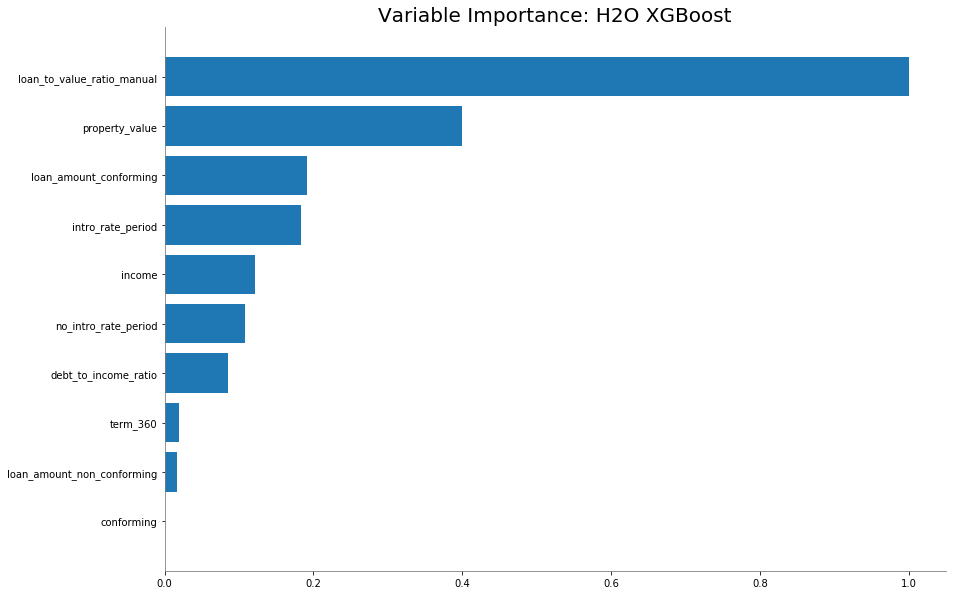

In [497]:
mxgb_lucky.varimp_plot()

In [498]:
shap_values_mxgb_lucky, expected_value_mxgb_lucky = get_shapley(mxgb_lucky, train, X)

First 5 rows of contributions:



no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_amount_conforming,loan_amount_non_conforming,loan_to_value_ratio_manual,BiasTerm
-0.0110492,-0.0141101,0.251469,-0.233267,0.0931876,0.0134542,5.82469e-05,0.0248598,0.00181334,0.632949,-2.29302
-0.0164162,-0.0142252,-0.22185,-0.0606487,-0.140746,0.0184583,4.85779e-05,-0.144267,0.00387476,0.180332,-2.29302
0.0448953,-1.03705,0.444195,-0.0026029,-0.0273545,-0.00354076,4.71099e-05,0.226866,0.0211189,0.32127,-2.29302
-0.060267,-0.0388257,-0.530579,-0.0261059,-0.0915306,0.0159233,8.2101e-05,-0.209046,0.00361746,-2.08811,-2.29302
-0.00896919,-0.0103258,0.284742,-0.0882806,0.173738,0.0142615,7.6978e-05,0.0633534,0.00219521,0.709042,-2.29302


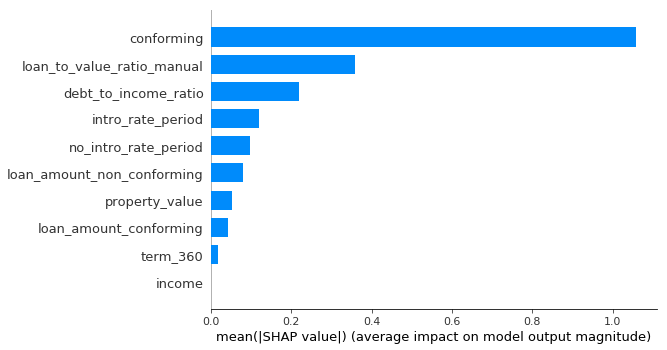

In [499]:
shap.summary_plot(shap_values_mxgb_lucky, X, plot_type="bar")

In [500]:
## Depth 10 is usually plenty of depth for most datasets, but you never know
hyper_params = {'max_depth' : list(range(1,30,2))}
#hyper_params = {max_depth = [4,6,8,12,16,20]} ##faster for larger datasets

#Build initial GBM Model
mgbm_grid = H2OGradientBoostingEstimator(
        # monotonicity constraints
        monotone_constraints=mono_constraints,
        # more trees is better if the learning rate is small enough 
        # here, use "more than enough" trees - we have early stopping
        ntrees=10000,
        # smaller learning rate is better
        # since we have learning_rate_annealing, we can afford to start with a 
        # bigger learning rate
        learn_rate=0.05,
        # learning rate annealing: learning_rate shrinks by 1% after every tree 
        # (use 1.00 to disable, but then lower the learning_rate)
        learn_rate_annealing = 0.99,
        # sample 80% of rows per tree
        sample_rate = 0.8,
        # sample 80% of columns per split
        col_sample_rate = 0.8,
        # fix a random number generator seed for reproducibility
        seed = 1234,
        # score every 10 trees to make early stopping reproducible 
        # (it depends on the scoring interval)
        score_tree_interval = 10, 
        # early stopping once the validation AUC doesn't improve by at least 0.01% for 
        # 5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4)

#Build grid search with previously made GBM and hyper parameters
grid = H2OGridSearch(mgbm_grid,hyper_params,
                         grid_id = 'depth_grid',
                         search_criteria = {'strategy': "Cartesian"})


#Train grid search
grid.train(x=X, 
           y=Y,
           training_frame = train)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [501]:
print(grid)

     max_depth            model_ids              logloss
0           21  depth_grid_model_11   0.2645011016768135
1           17   depth_grid_model_9  0.26451907137328906
2           29  depth_grid_model_15   0.2645329066335953
3           27  depth_grid_model_14  0.26453602685579203
4           23  depth_grid_model_12   0.2645616923948528
5           19  depth_grid_model_10   0.2646064795895587
6           25  depth_grid_model_13   0.2646163827632596
7           15   depth_grid_model_8  0.26483753228965223
8           13   depth_grid_model_7  0.26495797364004575
9           11   depth_grid_model_6   0.2653119083492382
10           9   depth_grid_model_5   0.2655664973445964
11           7   depth_grid_model_4   0.2664401448056813
12           5   depth_grid_model_3   0.2673941076924646
13           3   depth_grid_model_2   0.2690816149675114
14           1   depth_grid_model_1  0.27748286135837663



In [502]:
## sort the grid models by decreasing AUC
sorted_grid = grid.get_grid(sort_by='auc',decreasing=True)
print(sorted_grid)

     max_depth            model_ids                 auc
0           29  depth_grid_model_15  0.7955323516381719
1           21  depth_grid_model_11  0.7954780981802763
2           23  depth_grid_model_12  0.7954585923447204
3           25  depth_grid_model_13  0.7953764398821124
4           17   depth_grid_model_9   0.795355327374532
5           27  depth_grid_model_14  0.7953278527485446
6           19  depth_grid_model_10  0.7953063004991061
7           15   depth_grid_model_8  0.7948454519224071
8           13   depth_grid_model_7  0.7945037537956987
9           11   depth_grid_model_6  0.7937324194127457
10           9   depth_grid_model_5  0.7931378556904065
11           7   depth_grid_model_4  0.7911739743410248
12           5   depth_grid_model_3  0.7892920590927648
13           3   depth_grid_model_2  0.7857512431786213
14           1   depth_grid_model_1  0.7664729380756428



In [503]:
max_depths = sorted_grid.sorted_metric_table()['max_depth'][0:5]
new_max = int(max(max_depths, key=int))
new_min = int(min(max_depths, key=int))

print("MaxDepth", new_max)
print("MinDepth", new_min)

MaxDepth 29
MinDepth 17


In [504]:
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : list(range(new_min,new_max+1,1)),
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(4,13)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-3
                   }

In [505]:
gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # smaller learning rate is better
                    # since we have learning_rate_annealing, we can afford to start with a 
                    # bigger learning rate
                    learn_rate=0.05,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=X, 
           y=Y,
           ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
           max_runtime_secs = 3600, 
           training_frame = train)

print(final_grid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
      col_sample_rate col_sample_rate_change_per_level  \
0                0.52                              1.0   
1                 0.9                              1.1   
2                0.85                             1.07   
3                0.48                             0.99   
4                0.75                             0.94   
5                0.92                             1.06   
6                 0.6                              1.0   
7                 0.7                             1.08   
8                0.49                             1.04   
9                0.96                              1.1   
10               0.92                             1.04   
11               0.63                              1.0   
12               0.69                             0.97   
13               0.91                             0.96   
14               0.25                            

[100 rows x 13 columns]



In [506]:
# Sort the grid models by AUC
sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)

print(sorted_final_grid)

      col_sample_rate col_sample_rate_change_per_level  \
0                0.52                              1.0   
1                 0.9                              1.1   
2                0.48                             0.99   
3                0.96                              1.1   
4                0.91                             0.96   
5                0.75                             0.94   
6                0.92                             1.06   
7                 0.7                             1.08   
8                0.85                             1.07   
9                 0.6                              1.0   
10               0.49                             1.04   
11               0.63                              1.0   
12               0.92                             1.04   
13               0.87                              1.0   
14               0.38                             1.07   
15               0.25                             1.04   
16            

[100 rows x 13 columns]



In [507]:
#Get the best model from the list (the model name listed at the top of the table)
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(test)
print(performance_best_model.auc())

0.7844769657165537


In [510]:
## Depth 10 is usually plenty of depth for most datasets, but you never know
hyper_params = {'max_depth' : list(range(1,30,2))}
#hyper_params = {max_depth = [4,6,8,12,16,20]} ##faster for larger datasets

#Build initial GBM Model
mxgb_grid = H2OXGBoostEstimator(
        # monotonicity constraints
        monotone_constraints=mono_constraints,
        # more trees is better if the learning rate is small enough 
        # here, use "more than enough" trees - we have early stopping
        ntrees=10000,
        # smaller learning rate is better
        # since we have learning_rate_annealing, we can afford to start with a 
        # bigger learning rate
        learn_rate=0.05,
        # learning rate annealing: learning_rate shrinks by 1% after every tree 
        # (use 1.00 to disable, but then lower the learning_rate)
        # learn_rate_annealing = 0.99,
        # sample 80% of rows per tree
        sample_rate = 0.8,
        # sample 80% of columns per split
        col_sample_rate = 0.8,
        # fix a random number generator seed for reproducibility
        seed = 1234,
        # score every 10 trees to make early stopping reproducible 
        # (it depends on the scoring interval)
        score_tree_interval = 10, 
        # early stopping once the validation AUC doesn't improve by at least 0.01% for 
        # 5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4)

#Build grid search with previously made GBM and hyper parameters
grid_xgb = H2OGridSearch(mxgb_grid,hyper_params,
                         grid_id = 'depth_grid',
                         search_criteria = {'strategy': "Cartesian"})


#Train grid search
grid_xgb.train(x=X, 
           y=Y,
           training_frame = train)

In [ ]:
print(grid_xgb)

In [ ]:
## sort the grid models by decreasing AUC
sorted_grid_xgb = grid_xgb.get_grid(sort_by='auc',decreasing=True)
print(sorted_grid_xgb)

In [ ]:
max_depths_xgb = sorted_grid_xgb.sorted_metric_table()['max_depth'][0:5]
new_max_xgb = int(max(max_depths_xgb, key=int))
new_min_xgb = int(min(max_depths_xgb, key=int))

print("MaxDepth", new_max_xgb)
print("MinDepth", new_min_xgb)